# **RQ2: How do architectural models differ when generated through an interactive process?**

# **COCOME Case Study**

The idea is to identify/look for architectural characteristics that appeared due to the user's choices (centroids).

Indicators:
*   Architectural objectives such as: *#changes* and *pas* (2D space). Univariate and bi-variate analyses. Types of clusters identified in the objective space.
*   Common (intersection) and different models in the search spaces. This can be assessed by looking at the sequences of (types of) refactoring actions used in each dataset.
  *   Shapes of search trees for refactoring actions (types only) and distances among trees.
  *   Frequency of (or most common) refactoring actions (types only) used in the architectures.




In [52]:
#!pip install altair --quiet
#!pip install pca --quiet
#!pip install zss --quiet
#!pip install pymoo --quiet 
##!pip install dataframe_image --quiet
#!pip install distinctipy --quiet
##!pip install fastDamerauLevenshtein --quiet
#!pip install opentsne --quiet
#!pip install yellowbrick --quiet
#!pip install plotly --quiet
#!pip install networkx --quiet
#!pip install matplotlib_venn --quiet

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn2
#import dataframe_image as dfi
from PIL import Image
import networkx as nx
import seaborn as sns
from networkx.drawing.nx_agraph import graphviz_layout

In [54]:
# This is the class that imports all the functions needed for the analysis
from architecturespaceanalyzer import ArchitectureSpaceAnalyzer 

---

## **File downloads and Parsing**

In [55]:
# This is the reference Pareto front/space
NSGAII_PROJECT_NAME = 'nsgaii-cocome-1000-eval'
NSGAII_DATAPATH =  './zips/'+ NSGAII_PROJECT_NAME +'.zip' 

### *Non-interactive run*

In [56]:
# This is the non-interactive run (100 eval, length 4)
NSGAII_IT0_100_PROJECT_NAME = 'nsgaii-cocome-sbspe-100-eval-it-0'
NSGAII_IT0_100_DATAPATH =  './zips/'+ NSGAII_IT0_100_PROJECT_NAME +'.zip' 

### _Interactive runs_

In [57]:
# cocome 1st step of 50 eval, length 2
NSGAII_IT0_50_PROJECT_NAME = 'nsgaii-cocome-sbspe-50-eval-it-0-l-2'
NSGAII_IT0_50_DATAPATH =  './zips/' + NSGAII_IT0_50_PROJECT_NAME +'.zip' 

In [58]:
# cocome 2nd step of 50 eval, length 2 (using centroid 317)
NSGAII_IT1_50_C317_PROJECT_NAME = 'nsgaii-cocome-sbspe-50-eval-it-1-l-2-centroid-317'
NSGAII_IT1_50_C317_DATAPATH =  './zips/' + NSGAII_IT1_50_C317_PROJECT_NAME +'.zip' 

In [59]:
# cocome 2nd step of 50 eval, length 2 (using centroid 358)
NSGAII_IT1_50_C358_PROJECT_NAME = 'nsgaii-cocome-sbspe-50-eval-it-1-l-2-centroid-358'
NSGAII_IT1_50_C358_DATAPATH =  './zips/' + NSGAII_IT1_50_C358_PROJECT_NAME +'.zip' 

In [60]:
%%capture
!unzip -o $NSGAII_DATAPATH -d datasets
!unzip -o $NSGAII_IT0_100_DATAPATH -d datasets
!unzip -o $NSGAII_IT0_50_DATAPATH -d datasets
!unzip -o $NSGAII_IT1_50_C317_DATAPATH -d datasets
!unzip -o $NSGAII_IT1_50_C358_DATAPATH -d datasets

In [61]:
#!rm -r 'datasets'

# **ANALYSIS OF ARCHITECTURAL MODELS**

In [62]:
# All possible labels for solutions (for all datasets)
ALL_CLUSTER_LABELS = ['- / - / very-few / very-few',
  '- / - / very-few / few',
  '- / - / very-few / average',
  '- / - / very-few / some',
  '- / - / very-few / many',
  '- / - / few / very-few',
  '- / - / few / few',
  '- / - / few / average',
  '- / - / few / some',
  '- / - / few / many',
  '- / - / average / very-few',
  '- / - / average / few',
  '- / - / average / average',
  '- / - / average / some',
  '- / - / average / many',
  '- / - / some / very-few',
  '- / - / some / few',
  '- / - / some / average',
  '- / - / some / some',
  '- / - / some / many',
  '- / - / many / very-few',
  '- / - / many / few',
  '- / - / many / average',
  '- / - / many / some',
  '- / - / many / many']

In [63]:
OBJS_CHANGES_PAS = ['#changes', 'pas'] # Only considering these 2 objectives
PROBLEM_OBJECTIVES = ['perfQ', 'reliability']+OBJS_CHANGES_PAS

# Global (common) ranges for the 2 objectives
CHANGES_LIMITS = (1,84)
PAS_LIMITS = (0,86)

In [64]:
def get_values_as_dataframe(countops, algo, budget):
  operations_index = [1,2,3,4]*4
  refactions_index = [item for sublist in countops[0] for item in sublist]
  refactions_frequencies = {(algo,budget): [item for sublist in countops[1] for item in sublist]}

  return operations_index, refactions_index, refactions_frequencies

In [65]:
def plot3(sets3, titles=['', '', ''], colors=['tab:red', 'tab:green', 'tab:blue'], ax=None, percentage=True):
  total = len(sets3[0].union(sets3[1], sets3[2]))
  print("Union of solutions:", total)
  if percentage:
    venn3(sets3, set_labels=tuple(titles), set_colors=tuple(colors), subset_label_formatter=lambda x: f"{(x/total):1.0%}", ax=ax)
  else:
    venn3(sets3, set_labels=tuple(titles), set_colors=tuple(colors), ax=ax)

def plot2(sets2, titles=['', ''], colors=['tab:red', 'tab:green'], ax=None, percentage=True):
  total = len(sets2[0].union(sets2[1]))
  print("Union of solutions:", total)
  if percentage:
    venn2(sets2, set_labels=tuple(titles), set_colors=tuple(colors), subset_label_formatter=lambda x: f"{(x/total):1.0%}", ax=ax)
  else:
    venn2(sets2, set_labels=tuple(titles), set_colors=tuple(colors), ax=ax)

---
## **Reference Pareto Front (1000)**

In [66]:
# Initialize the project/file
ref1000_space = ArchitectureSpaceAnalyzer(objectives=OBJS_CHANGES_PAS)
ref1000_space.initialize_dataset(NSGAII_PROJECT_NAME)
print(ref1000_space.PROJECT_NAME)

ref1000_space.set_labels(ALL_CLUSTER_LABELS)
ref1000_space.CHANGES_LIMITS = CHANGES_LIMITS
ref1000_space.PAS_LIMITS = PAS_LIMITS

# Read all the objectives and refactoring actions
# Note that length of sequences is 4
_ = ref1000_space.read_file_batch(1,31, length=4, arguments=0, option='all')

project: nsgaii-cocome-1000-eval
objective files= 31
refactoring actions files= 31
nsgaii-cocome-1000-eval
Reading files ... 1 31 all
  file 0
  file 1
  file 2
  file 3
  file 4
  file 5
  file 6
  file 7
  file 8
  file 9
  file 10
  file 11
  file 12
  file 13
  file 14
  file 15
  file 16
  file 17
  file 18
  file 19
  file 20
  file 21
  file 22
  file 23
  file 24
  file 25
  file 26
  file 27
  file 28
  file 29
  file 30
done.


In [67]:
# This the global palette for all cluster labels
sns.color_palette(ref1000_space.CLUSTERS_COLORS)

[(0.0, 1.0, 0.0),
 (1.0, 0.0, 1.0),
 (0.0, 0.5019607843137255, 1.0),
 (1.0, 0.5019607843137255, 0.0),
 (0.5019607843137255, 0.7490196078431373, 0.5019607843137255),
 (0.34509803921568627, 0.0, 0.6470588235294118),
 (0.7411764705882353, 0.00784313725490196, 0.047058823529411764),
 (0.2, 0.4980392156862745, 0.00784313725490196),
 (0.7411764705882353, 0.4745098039215686, 0.9921568627450981),
 (0.984313725490196, 0.9921568627450981, 0.25882352941176473),
 (0.0, 1.0, 1.0),
 (0.0, 1.0, 0.5019607843137255),
 (0.0, 0.5019607843137255, 0.5019607843137255),
 (0.7529411764705882, 0.25882352941176473, 0.5098039215686274),
 (0.0, 0.0, 1.0),
 (0.5372549019607843, 0.8627450980392157, 0.00784313725490196),
 (0.5294117647058824, 0.9607843137254902, 0.9764705882352941),
 (0.9333333333333333, 0.7058823529411765, 0.6274509803921569),
 (0.396078431372549, 0.4235294117647059, 0.7215686274509804),
 (0.2901960784313726, 0.19607843137254902, 0.21176470588235294),
 (0.5450980392156862, 0.13333333333333333, 0.996078431372549),
 (0.6392156862745098, 0.3607843137254902, 0.03137254901960784),
 (1.0, 0.0, 0.5019607843137255),
 (0.21568627450980393, 0.7215686274509804, 0.7725490196078432),
 (0.03529411764705882, 0.7215686274509804, 0.2235294117647059)]

In [68]:
ref1000_space.objectives_df.head()

solID     perfQ  reliability  #changes   pas
0  17566  0.144165     0.762310      1.45  11.0
1  17811  0.251431     0.964951      6.18   7.0
2  22051  0.251435     0.964894     12.55  14.0
3  22521 -0.085576     0.865167      4.73   5.0
4  22660  0.231738     0.568227      4.54   2.0

Statistics for #changes and pas objectives.

In [69]:
ref1000_space.objectives_df[OBJS_CHANGES_PAS].describe()

#changes         pas
count  492.000000  492.000000
mean    20.089350   18.516260
std     18.861371   19.308033
min      1.450000    0.000000
25%      6.180000    6.000000
50%     12.520000   11.000000
75%     26.157500   23.000000
max     82.940000   86.000000

In [70]:
#ref1000_space.refactions_df.head()

### *Metrics*

In [71]:
ref1000_pf = ref1000_space.get_pareto_front()
ref1000_norm_pf = ref1000_space.compute_pareto_front()

# Look only at some of the metrics (NPS, HV, DE)
metrics1000_dict = ref1000_space.compute_all_metrics(ref_point=(1,1), reference_front=ref1000_norm_pf)
metrics1000_dict['point'] = 'reference'
print("Pareto front metrics (#changes versus pas):")
print(metrics1000_dict)
print('\tNPS', metrics1000_dict['NPS'], 'solutions')
print('\tHV', metrics1000_dict['HV'])
print('\tDE', metrics1000_dict['DE'])

ref1000_pf.head()

Pareto front metrics (#changes versus pas):
{'C_AB': 1.0, 'C_BA': 1.0, 'IGDPlus': 0.0, 'HV': 0.9977397711803703, 'NPS': 13, 'NSolutions': 324, 'NSequences': 492, 'DE': 0.6071946861249314, 'point': 'reference'}
	NPS 13 solutions
	HV 0.9977397711803703
	DE 0.6071946861249314


#changes  pas
0      5.08  0.0
1      4.35  2.0
2      4.54  2.0
3      1.64  5.0
4      4.73  2.0

### *Clustering*

In [72]:
# Try k-Means
#labels, _, silhouette = ref1000_space.run_kmeans(k=5, show_silhouette=False) 

# Try agglomerative clustering
labels, _, silhouette = ref1000_space.run_agglomerative(k=3, threshold=None, show_dendogram=False) 
ref1000_space.assign_cluster_labels(labels) # This effectively assigns the labels

Number of clusters = 3
Labels for instances: [0 0 0 0 0 0 2 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 2 2 2 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 0 2 2 2 0 0 0 0 0 0
 0 2 2 2 1 1 2 1 1 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 2 1 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 2 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 2 0 0 2 0 0 0 2 0 0 0 2 2 0 0 0 1 1 1 1 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 1 2 0 2 0 1 2
 0 1 2 0 0 0 0 0 0 0 0 0 0 0 2 0 0 2 2 0 1 0 0 1 0 1 1 1 1 0 0 1 0 1 0 0 0
 0 0 0 2 0 1 2 2 1 0 1 1 2 1 0 0 0 1 0 1 0 1 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0
 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 2 0 0 2 2 0 2 2 0 0 0 0 0 0 2 0 0 2 0
 2 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 2 2 0 0 2 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 2 0 

perfQ  reliability  #changes   pas  cluster  \
28   0.298296     0.858573     11.98  10.0        0   
357  0.189971     0.970340     61.37  69.0        1   
336  0.269195     0.965051     37.18  37.0        2   

                           label  
28   - / - / very-few / very-few  
357          - / - / some / many  
336    - / - / average / average

In [73]:
# Graphical representations of objectives in 2D space
ref1000_space.show_scatter_plot(x='#changes', y='pas', show_all_labels=True)
#ref1000_space.show_petal_plot(labels=True, size=(20,5))

Using alternatives as prototypes ... []


alt.HConcatChart(...)

In [74]:
ref1000_space.show_scatter_plot(x='#changes', y='pas', show_all_labels=True, pfonly=True)

Using alternatives as prototypes ... []


alt.HConcatChart(...)

In [75]:
ref1000_space.clusters_info()

  cluster 0 : 388 items 78.86 % - / - / very-few / very-few
  cluster 2 : 62 items 12.60 % - / - / average / average
  cluster 1 : 42 items 8.54 % - / - / some / many


In [76]:
ref1000_space.describe_cluster_labels(objectives=OBJS_CHANGES_PAS)

Using predefined limits (0, 1.0)
Using predefined limits (1, 84)
Using predefined limits (0, 86)
Using predefined limits (0, 1.0)


objective    min    max  unit     label
5   #changes   0.90  17.54  unit  very-few
6   #changes  17.54  34.18  unit       few
7   #changes  34.18  50.82  unit   average
8   #changes  50.82  67.46  unit      some
9   #changes  67.46  84.10  unit      many
10       pas  -0.10  17.14  unit  very-few
11       pas  17.14  34.38  unit       few
12       pas  34.38  51.62  unit   average
13       pas  51.62  68.86  unit      some
14       pas  68.86  86.10  unit      many

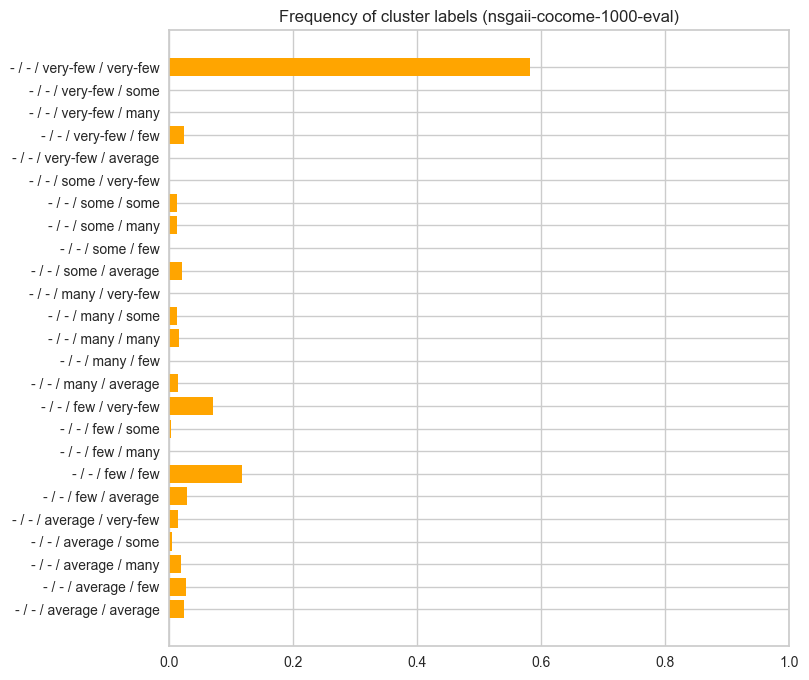

{'- / - / average / average': 0.024390243902439025,
 '- / - / average / few': 0.026422764227642278,
 '- / - / average / many': 0.018292682926829267,
 '- / - / average / some': 0.0040650406504065045,
 '- / - / average / very-few': 0.014227642276422764,
 '- / - / few / average': 0.028455284552845527,
 '- / - / few / few': 0.11788617886178862,
 '- / - / few / many': 0.0,
 '- / - / few / some': 0.0020325203252032522,
 '- / - / few / very-few': 0.07113821138211382,
 '- / - / many / average': 0.014227642276422764,
 '- / - / many / few': 0.0,
 '- / - / many / many': 0.016260162601626018,
 '- / - / many / some': 0.012195121951219513,
 '- / - / many / very-few': 0.0,
 '- / - / some / average': 0.02032520325203252,
 '- / - / some / few': 0.0,
 '- / - / some / many': 0.012195121951219513,
 '- / - / some / some': 0.012195121951219513,
 '- / - / some / very-few': 0.0,
 '- / - / very-few / average': 0.0,
 '- / - / very-few / few': 0.024390243902439025,
 '- / - / very-few / many': 0.0,
 '- / - / very

In [77]:
ref1000_space.show_cluster_labels_distribution(size=(8,8))

### *Visualizations (density)*

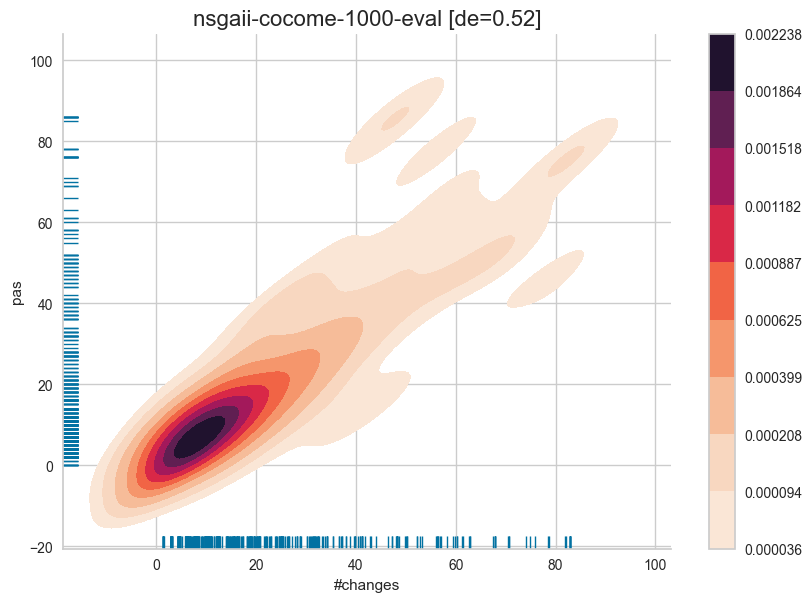

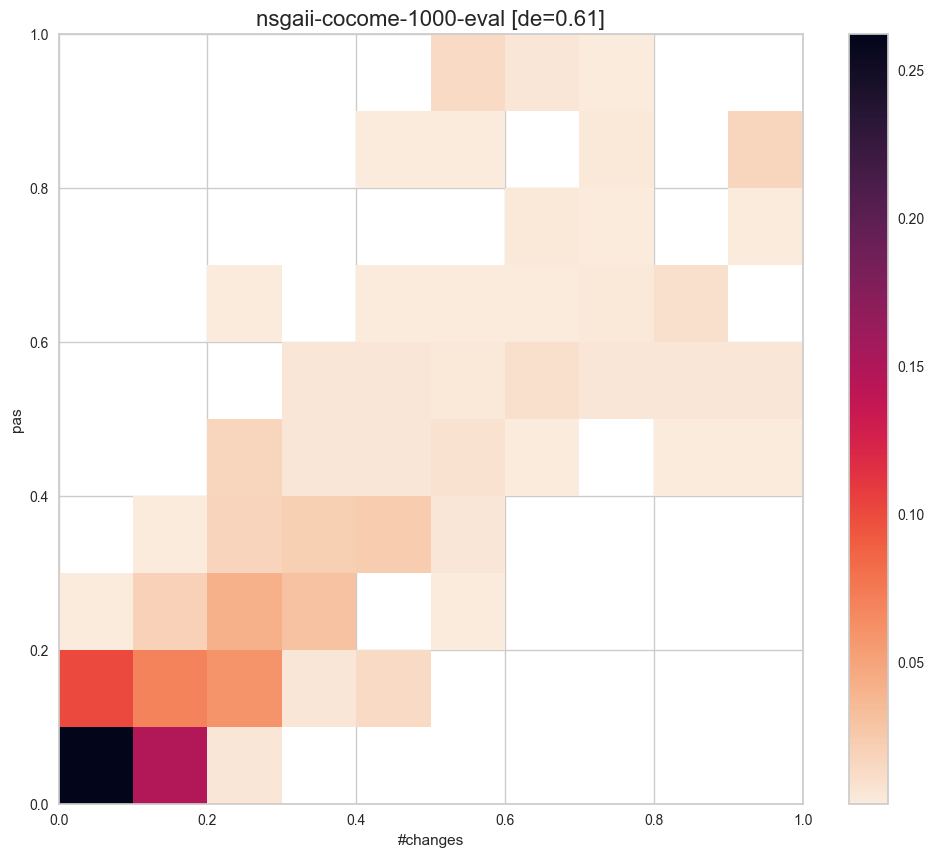

In [78]:
# Density plots for the 2D space of changes versus pas
ref1000_space.show_density_plot(objectives=OBJS_CHANGES_PAS, normalize=False) 
ref1000_space.show_density_plot(kind='bins', objectives=OBJS_CHANGES_PAS, normalize=True, bins=10)

In [79]:
# Entropy of 2D space
de_2D = ref1000_space.compute_density_entropy(normalize=True, bins=10)
print("The density entropy is:", de_2D)

The density entropy is: 0.6071946861249314


---
## **Iteration 0 (interactive, 50)**

In [80]:
# Initialize the project/file
it0_50_space = ArchitectureSpaceAnalyzer(objectives=OBJS_CHANGES_PAS)
it0_50_space.initialize_dataset(NSGAII_IT0_50_PROJECT_NAME)
print(it0_50_space.PROJECT_NAME)

it0_50_space.set_labels(ALL_CLUSTER_LABELS)
it0_50_space.CHANGES_LIMITS = CHANGES_LIMITS
it0_50_space.PAS_LIMITS = PAS_LIMITS

# Read all the objectives and refactoring actions
# Note that length of sequences is 2
_ = it0_50_space.read_file_batch(1,31, length=2, arguments=0, option='all')

project: nsgaii-cocome-sbspe-50-eval-it-0-l-2
objective files= 31
refactoring actions files= 31
nsgaii-cocome-sbspe-50-eval-it-0-l-2
Reading files ... 1 31 all
  file 0
  file 1
  file 2
  file 3
  file 4
  file 5
  file 6
  file 7
  file 8
  file 9
  file 10
  file 11
  file 12
  file 13
  file 14
  file 15
  file 16
  file 17
  file 18
  file 19
  file 20
  file 21
  file 22
  file 23
  file 24
  file 25
  file 26
  file 27
  file 28
  file 29
  file 30
done.


In [81]:
it0_50_space.objectives_df.head()

solID     perfQ  reliability  #changes   pas
0      2  0.144165     0.762310      1.45  11.0
1    965  0.368136    -0.405718      3.44  12.0
2   1055  0.368136    -0.405718      3.44  12.0
3   1221  0.077317     0.854894      3.09  10.0
4   1251  0.077317     0.854894      3.09  10.0

Statistics for #changes and pas objectives.

In [82]:
it0_50_space.objectives_df[OBJS_CHANGES_PAS].describe()

#changes         pas
count  496.000000  496.000000
mean     4.806996    8.913306
std      2.629103    4.115325
min      1.450000    0.000000
25%      3.090000    6.000000
50%      3.280000    8.000000
75%      5.280000   11.000000
max     15.720000   26.000000

In [83]:
#it0_50_space.refactions_df.head()

### *Metrics* - Not need to analyze them in this dataset

In [84]:
ref50_it0_pf = it0_50_space.get_pareto_front()
#ref50_it0_norm_pf = it0_50_space.compute_pareto_front(invert_max=True)

# The reference front is the ref1000 space
metrics50_it0_dict = it0_50_space.compute_all_metrics(ref_point=(1,1), reference_front=ref1000_norm_pf)
metrics50_it0_dict['point'] = 'it-0'
print("Pareto front metrics (#changes versus pas):")
print(metrics50_it0_dict)

ref50_it0_pf.head()

Pareto front metrics (#changes versus pas):
{'C_AB': 0.0, 'C_BA': 1.0, 'IGDPlus': 0.1589531636518434, 'HV': 0.9561209638294432, 'NPS': 12, 'NSolutions': 110, 'NSequences': 475, 'DE': 0.2358650119962152, 'point': 'it-0'}


#changes  pas
0      3.09  2.0
1      3.44  2.0
2      3.09  3.0
3      6.56  0.0
4      1.64  5.0

### *Clustering*
Only for the purpose of showing the centroids chosen for Iteration 1

In [85]:
# Try k-Means
#labels, _, silhouette = it1_50_c258_space.run_kmeans(k=5, show_silhouette=False) 

# Try agglomerative clustering
labels, _, silhouette = it0_50_space.run_agglomerative(k=3, threshold=None, show_dendogram=False) 
it0_50_space.assign_cluster_labels(labels) # This effectively assigns the labels

Number of clusters = 3
Labels for instances: [0 0 0 0 0 2 0 0 2 0 0 0 0 0 0 0 0 0 0 0 1 0 0 2 0 2 0 0 0 0 0 0 0 0 0 0 0
 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 2 0 0 0
 0 0 2 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2
 0 0 0 2 0 0 0 0 0 2 0 0 2 0 0 0 2 1 0 0 0 0 0 2 0 0 0 2 0 0 0 0 0 0 1 0 2
 0 0 0 0 1 1 1 0 0 0 0 0 0 2 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 2 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 1 0 0 0 2 2 0 0 0 2 0 0
 0 1 1 2 0 2 0 1 1 1 0 0 0 0 0 0 2 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 2 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 2 0 0 0 0 2 2 0 0 0 0 0 0 0 1 2 1 0 1 2 0 2 0 0 0 0 0 2 0
 0 0 0 1 1 0 0 0 0 2 0 0 0 0 0 0 1 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 2 0 1 0 0 0 2 0 0 0 0 2 0 0 0 0 0 0 0 1 0 2 0 0 0 0 0
 0 0 0 2 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 2 0 1 0 

perfQ  reliability  #changes   pas  cluster  \
219  0.205989     0.409528      3.28   9.0        0   
374  0.205965     0.871900      8.52  21.0        1   
89   0.105941     0.269325      9.75   5.0        2   

                           label  
219  - / - / very-few / very-few  
374       - / - / very-few / few  
89   - / - / very-few / very-few

In [86]:
#it0_50_space.show_petal_plot(labels=True, size=(20,5))

This is the **first centroid (317)** chosen as a decision point for the next rounds of search.



In [87]:
centroid_series = it0_50_space.tagged_objectives_df.loc[317]
print(centroid_series)
centroid_rows = it0_50_space.tagged_objectives_df[it0_50_space.tagged_objectives_df['solID']==1419]
centroid_rows

perfQ                             0.216461
reliability                       0.759612
#changes                              3.28
pas                                   10.0
cluster                                  0
label          - / - / very-few / very-few
solID                                 1419
Name: 317, dtype: object


perfQ  reliability  #changes   pas  cluster  \
239  0.357302     0.763772      4.73   7.0        0   
317  0.216461     0.759612      3.28  10.0        0   
346  0.314372     0.763086      9.02   4.0        2   
471  0.017614     0.945651      3.28  11.0        0   

                           label  solID  
239  - / - / very-few / very-few   1419  
317  - / - / very-few / very-few   1419  
346  - / - / very-few / very-few   1419  
471  - / - / very-few / very-few   1419

This is the **second centroid (358)** chosen as a decision point for the next rounds of search.

In [88]:
centroid_series = it0_50_space.tagged_objectives_df.loc[358]
print(centroid_series)
centroid_rows = it0_50_space.tagged_objectives_df[it0_50_space.tagged_objectives_df['solID']==838]
centroid_rows

perfQ                            -0.014243
reliability                       0.853851
#changes                              3.28
pas                                    8.0
cluster                                  0
label          - / - / very-few / very-few
solID                                  838
Name: 358, dtype: object


perfQ  reliability  #changes  pas  cluster  \
358 -0.014243     0.853851      3.28  8.0        0   

                           label  solID  
358  - / - / very-few / very-few    838

**Note that both centroids have more or less the same architectural characteristics with respect to #changes and pas. However, they differ in their tradeoffs with respect to performance and reliability.**

In [89]:
it0_50_space.show_scatter_plot(x='#changes', y='pas', show_all_labels=True)

Using alternatives as prototypes ... []


alt.HConcatChart(...)

In [90]:
it0_50_space.show_scatter_plot(x='#changes', y='pas', show_all_labels=True, pfonly=True)

Using alternatives as prototypes ... []


alt.HConcatChart(...)

In [91]:
it0_50_space.clusters_info()

  cluster 0 : 416 items 83.87 % - / - / very-few / very-few
  cluster 2 : 52 items 10.48 % - / - / very-few / very-few
  cluster 1 : 28 items 5.65 % - / - / very-few / few


In [92]:
#it0_50_space.describe_cluster_labels(objectives=OBJS_CHANGES_PAS)

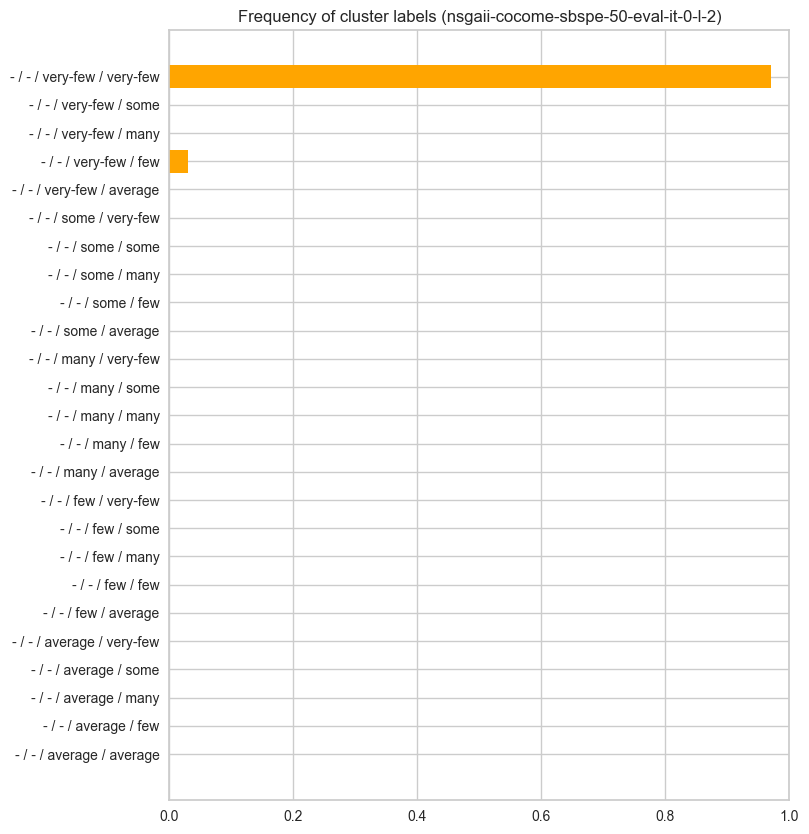

{'- / - / average / average': 0.0,
 '- / - / average / few': 0.0,
 '- / - / average / many': 0.0,
 '- / - / average / some': 0.0,
 '- / - / average / very-few': 0.0,
 '- / - / few / average': 0.0,
 '- / - / few / few': 0.0,
 '- / - / few / many': 0.0,
 '- / - / few / some': 0.0,
 '- / - / few / very-few': 0.0,
 '- / - / many / average': 0.0,
 '- / - / many / few': 0.0,
 '- / - / many / many': 0.0,
 '- / - / many / some': 0.0,
 '- / - / many / very-few': 0.0,
 '- / - / some / average': 0.0,
 '- / - / some / few': 0.0,
 '- / - / some / many': 0.0,
 '- / - / some / some': 0.0,
 '- / - / some / very-few': 0.0,
 '- / - / very-few / average': 0.0,
 '- / - / very-few / few': 0.03024193548387097,
 '- / - / very-few / many': 0.0,
 '- / - / very-few / some': 0.0,
 '- / - / very-few / very-few': 0.969758064516129}

In [93]:
it0_50_space.show_cluster_labels_distribution(size=(8,10))

### *Visualizations (density)*

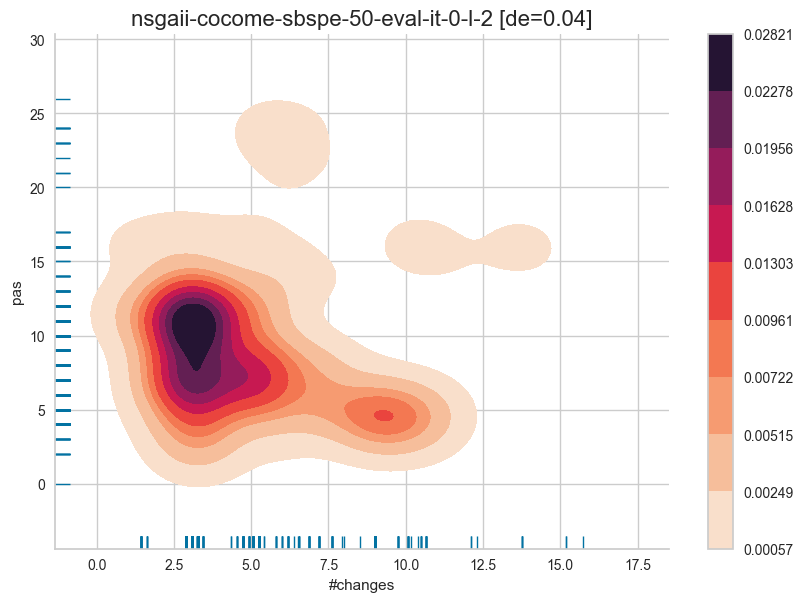

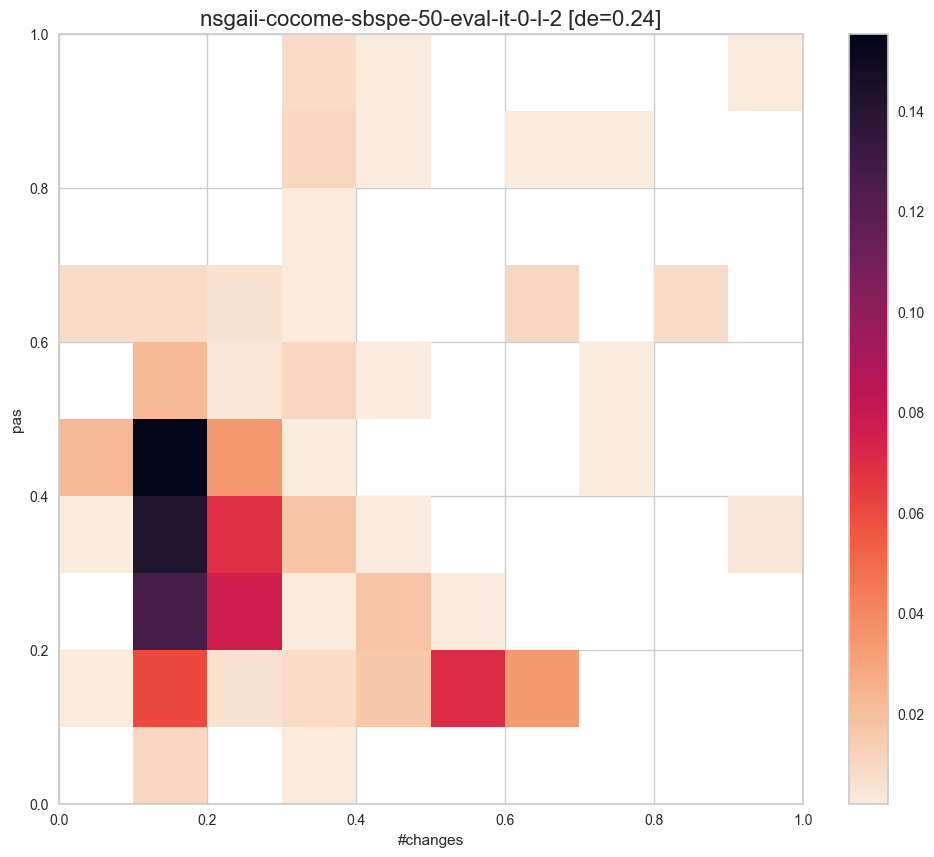

In [94]:
# Density plots for the 2D space of changes versus pas
it0_50_space.show_density_plot(objectives=OBJS_CHANGES_PAS, normalize=False) 
it0_50_space.show_density_plot(kind='bins', objectives=OBJS_CHANGES_PAS, normalize=True, bins=10)

In [95]:
# Entropy of 2D space
de_2D = it0_50_space.compute_density_entropy(normalize=True, bins=10)
print("The density entropy is:", de_2D)

The density entropy is: 0.2358650119962152


---
## **Iteration 1: Centroid 317 (interactive, 50)**
This centroid choice is about *very-few* #changes [3.28] and *very-few* pas [10]. It has also *basic* performance and *good* reliability.

In [96]:
# Initialize the project/file
it1_50_c317_space = ArchitectureSpaceAnalyzer(objectives=OBJS_CHANGES_PAS)
it1_50_c317_space.initialize_dataset(NSGAII_IT1_50_C317_PROJECT_NAME)
print(it1_50_c317_space.PROJECT_NAME)

it1_50_c317_space.set_labels(ALL_CLUSTER_LABELS)
it1_50_c317_space.CHANGES_LIMITS = CHANGES_LIMITS
it1_50_c317_space.PAS_LIMITS = PAS_LIMITS

# Read all the objectives and refactoring actions
# Note that length of sequences is 2
_ = it1_50_c317_space.read_file_batch(1,31, length=2, arguments=0, option='all')

project: nsgaii-cocome-sbspe-50-eval-it-1-l-2-centroid-317
objective files= 31
refactoring actions files= 31
nsgaii-cocome-sbspe-50-eval-it-1-l-2-centroid-317
Reading files ... 1 31 all
  file 0
  file 1
  file 2
  file 3
  file 4
  file 5
  file 6
  file 7
  file 8
  file 9
  file 10
  file 11
  file 12
  file 13
  file 14
  file 15
  file 16
  file 17
  file 18
  file 19
  file 20
  file 21
  file 22
  file 23
  file 24
  file 25
  file 26
  file 27
  file 28
  file 29
  file 30
done.


In [97]:
it1_50_c317_space.objectives_df.head()

solID     perfQ  reliability  #changes   pas
0    148  0.142708     0.710623      8.52   0.0
1    342  0.355600     0.818500      6.37  11.0
2    354  0.287485     0.829884      6.37  12.0
3    733  0.119599     0.891019      6.18  12.0
4   1077  0.316861     0.265851      8.52   7.0

Statistics for #changes and pas objectives.

In [98]:
it1_50_c317_space.objectives_df[OBJS_CHANGES_PAS].describe()

#changes         pas
count  495.000000  495.000000
mean     7.319778    6.389899
std      2.664027    4.433437
min      3.280000    0.000000
25%      6.180000    2.500000
50%      6.370000    6.000000
75%      8.330000   10.000000
max     27.520000   23.000000

In [99]:
#it1_50_c258_space.refactions_df.head()

### *Metrics*

In [100]:
ref50_it1_c317_pf = it1_50_c317_space.get_pareto_front()
#ref50_it1_c317_norm_pf = it1_50_c317_space.compute_pareto_front(invert_max=True)

# The reference front is the ref1000 space
metrics50_it1_c317_dict = it1_50_c317_space.compute_all_metrics(ref_point=(1,1), reference_front=ref1000_norm_pf)
metrics50_it1_c317_dict['point'] = 'it1-c317'
print("Pareto front metrics (#changes versus pas):")
print(metrics50_it1_c317_dict)

ref50_it1_c317_pf.head()

Pareto front metrics (#changes versus pas):
{'C_AB': 0.23076923076923078, 'C_BA': 1.0, 'IGDPlus': 0.09150814423433731, 'HV': 0.9733103745157123, 'NPS': 9, 'NSolutions': 97, 'NSequences': 461, 'DE': 0.25855916403983764, 'point': 'it1-c317'}


#changes  pas
0      4.92  0.0
1      6.37  0.0
2      6.56  0.0
3      4.73  2.0
4      8.52  0.0

In [101]:
complete_pf = ref50_it1_c317_pf.merge(it1_50_c317_space.objectives_df, on=OBJS_CHANGES_PAS)
complete_pf = complete_pf.drop_duplicates(subset=PROBLEM_OBJECTIVES)
print(complete_pf.shape)
complete_pf.to_csv('./datasets/it1_50_c317_pf.csv', index=False)
#ref50_it1_c317_pf.merge(it1_50_c317_space.objectives_df, on=OBJS_CHANGES_PAS).to_csv('it1_50_c317_pf.csv', index=False)

it1_50_c317_space.objectives_df.drop_duplicates(subset=PROBLEM_OBJECTIVES).to_csv('./datasets/it1_50_c317.csv', index=False)

(30, 5)


### *Clustering*

In [102]:
# Try k-Means
#labels, _, silhouette = it1_50_c258_space.run_kmeans(k=5, show_silhouette=False) 

# Try agglomerative clustering
labels, _, silhouette = it1_50_c317_space.run_agglomerative(k=3, threshold=None, show_dendogram=False) 
it1_50_c317_space.assign_cluster_labels(labels) # This effectively assigns the labels

Number of clusters = 3
Labels for instances: [1 2 2 2 2 1 0 0 1 0 1 2 1 2 2 1 2 1 1 2 1 0 1 2 2 1 2 2 1 2 2 1 1 2 2 1 2
 1 0 1 2 0 2 1 2 1 0 2 2 0 2 1 0 0 1 0 1 2 1 2 2 2 2 1 1 2 1 2 1 2 1 1 1 1
 1 2 2 2 2 1 0 1 2 1 2 2 0 2 2 2 2 2 2 0 2 2 1 1 0 2 2 2 0 2 2 0 1 2 1 0 0
 1 2 2 1 1 2 2 2 2 1 1 2 2 1 1 1 2 2 2 2 1 1 1 1 2 2 2 2 1 1 2 2 2 2 0 0 2
 2 2 0 2 1 1 1 2 2 1 2 0 1 1 0 1 0 0 1 1 2 2 0 2 2 2 1 2 0 1 2 1 2 1 0 2 1
 2 2 1 2 2 0 2 0 1 1 2 2 1 2 1 1 1 2 2 1 2 2 2 0 0 1 2 1 2 0 1 1 0 1 2 2 1
 2 1 0 2 2 0 2 1 0 2 0 0 2 2 2 1 1 2 2 0 1 0 1 2 0 2 2 2 1 2 2 2 1 1 1 1 2
 2 0 1 2 2 1 2 2 2 1 1 2 2 2 1 1 0 1 2 1 2 1 2 2 2 2 2 2 1 1 1 2 2 1 1 2 2
 1 1 1 1 1 1 1 2 2 1 0 2 1 1 0 2 1 0 2 2 1 1 2 1 2 1 1 0 1 1 2 2 0 1 0 2 2
 1 2 2 1 2 1 2 1 2 0 1 2 2 1 1 2 2 1 1 2 0 0 1 0 1 2 1 1 2 1 0 2 2 2 1 1 1
 1 1 2 2 1 1 2 2 2 2 1 1 1 2 2 1 2 1 1 1 2 2 2 2 2 1 1 2 2 2 1 1 2 1 1 2 2
 0 1 1 1 1 2 2 2 2 2 1 2 1 2 2 2 1 1 2 1 2 2 1 2 1 2 1 2 0 2 1 2 1 1 2 1 2
 1 2 1 2 2 1 1 0 2 0 2 0 1 2 2 2 2 1 2 1 2 1 2 1 2 1 2 

perfQ  reliability  #changes   pas  cluster  \
21   0.287322     0.831217     12.36  12.0        0   
276  0.141794     0.719572      6.72   2.0        1   
42   0.215392     0.857253      6.37   9.0        2   

                           label  
21   - / - / very-few / very-few  
276  - / - / very-few / very-few  
42   - / - / very-few / very-few

In [103]:
it1_50_c317_space.show_scatter_plot(x='#changes', y='pas', show_all_labels=True)
#it1_50_c258_space.show_petal_plot(labels=True, size=(20,5))

Using alternatives as prototypes ... []


alt.HConcatChart(...)

In [104]:
it1_50_c317_space.show_scatter_plot(x='#changes', y='pas', show_all_labels=True, pfonly=True)

Using alternatives as prototypes ... []


alt.HConcatChart(...)

In [105]:
it1_50_c317_space.clusters_info()

  cluster 2 : 237 items 47.88 % - / - / very-few / very-few
  cluster 1 : 195 items 39.39 % - / - / very-few / very-few
  cluster 0 : 63 items 12.73 % - / - / very-few / very-few


In [106]:
it1_50_c317_space.describe_cluster_labels(objectives=OBJS_CHANGES_PAS)

Using predefined limits (0, 1.0)
Using predefined limits (1, 84)
Using predefined limits (0, 86)
Using predefined limits (0, 1.0)


objective    min    max  unit     label
5   #changes   0.90  17.54  unit  very-few
6   #changes  17.54  34.18  unit       few
7   #changes  34.18  50.82  unit   average
8   #changes  50.82  67.46  unit      some
9   #changes  67.46  84.10  unit      many
10       pas  -0.10  17.14  unit  very-few
11       pas  17.14  34.38  unit       few
12       pas  34.38  51.62  unit   average
13       pas  51.62  68.86  unit      some
14       pas  68.86  86.10  unit      many

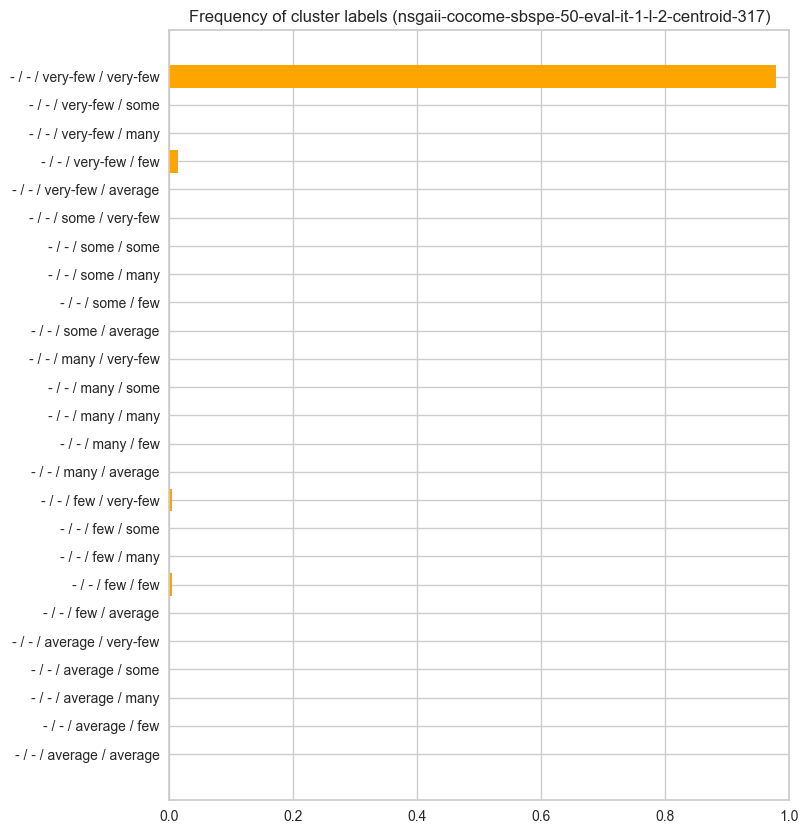

{'- / - / average / average': 0.0,
 '- / - / average / few': 0.0,
 '- / - / average / many': 0.0,
 '- / - / average / some': 0.0,
 '- / - / average / very-few': 0.0,
 '- / - / few / average': 0.0,
 '- / - / few / few': 0.00404040404040404,
 '- / - / few / many': 0.0,
 '- / - / few / some': 0.0,
 '- / - / few / very-few': 0.00404040404040404,
 '- / - / many / average': 0.0,
 '- / - / many / few': 0.0,
 '- / - / many / many': 0.0,
 '- / - / many / some': 0.0,
 '- / - / many / very-few': 0.0,
 '- / - / some / average': 0.0,
 '- / - / some / few': 0.0,
 '- / - / some / many': 0.0,
 '- / - / some / some': 0.0,
 '- / - / some / very-few': 0.0,
 '- / - / very-few / average': 0.0,
 '- / - / very-few / few': 0.014141414141414142,
 '- / - / very-few / many': 0.0,
 '- / - / very-few / some': 0.0,
 '- / - / very-few / very-few': 0.9777777777777777}

In [107]:
it1_50_c317_space.show_cluster_labels_distribution(size=(8,10))

### *Visualizations (density)*

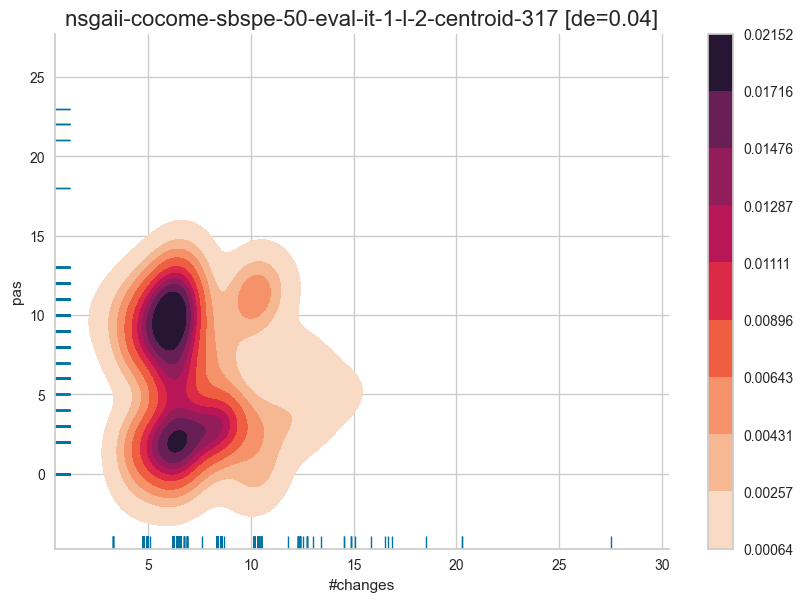

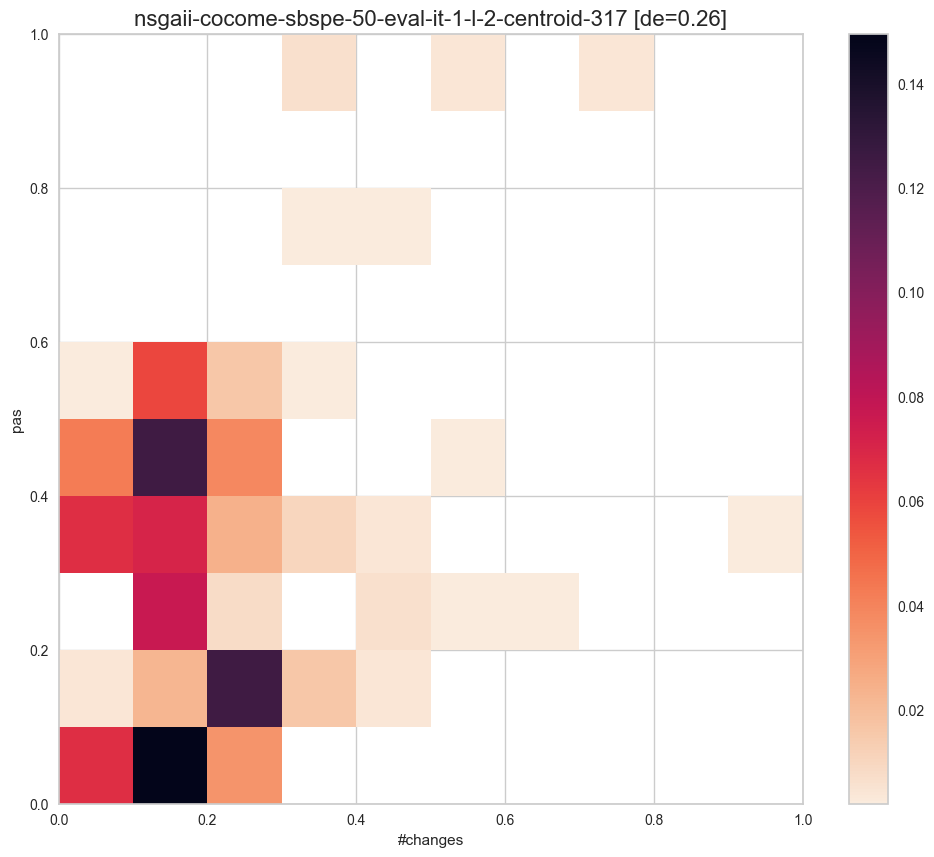

In [108]:
# Density plots for the 2D space of changes versus pas
it1_50_c317_space.show_density_plot(objectives=OBJS_CHANGES_PAS, normalize=False) 
it1_50_c317_space.show_density_plot(kind='bins', objectives=OBJS_CHANGES_PAS, normalize=True, bins=10)

In [109]:
# Entropy of 2D space
de_2D = it1_50_c317_space.compute_density_entropy(normalize=True, bins=10)
print("The density entropy is:", de_2D)

The density entropy is: 0.25855916403983764


---
## **Iteration 1: Centroid 358 (interactive, 50)**
This centroid choice is about *very-few* #changes [3.28] and *very-few* pas [8]. It has also *bad* performance and *very-good* reliability.

In [110]:
# Initialize the project/file
it1_50_c358_space = ArchitectureSpaceAnalyzer(objectives=OBJS_CHANGES_PAS)
it1_50_c358_space.initialize_dataset(NSGAII_IT1_50_C358_PROJECT_NAME)
print(it1_50_c358_space.PROJECT_NAME)

it1_50_c358_space.set_labels(ALL_CLUSTER_LABELS)
it1_50_c358_space.CHANGES_LIMITS = CHANGES_LIMITS
it1_50_c358_space.PAS_LIMITS = PAS_LIMITS

# Read all the objectives and refactoring actions
# Note that length of sequences is 2
_ = it1_50_c358_space.read_file_batch(1,31, length=2, arguments=0, option='all')

project: nsgaii-cocome-sbspe-50-eval-it-1-l-2-centroid-358
objective files= 31
refactoring actions files= 31
nsgaii-cocome-sbspe-50-eval-it-1-l-2-centroid-358
Reading files ... 1 31 all
  file 0
  file 1
  file 2
  file 3
  file 4
  file 5
  file 6
  file 7
  file 8
  file 9
  file 10
  file 11
  file 12
  file 13
  file 14
  file 15
  file 16
  file 17
  file 18
  file 19
  file 20
  file 21
  file 22
  file 23
  file 24
  file 25
  file 26
  file 27
  file 28
  file 29
  file 30
done.


In [111]:
it1_50_c358_space.objectives_df.head()

solID     perfQ  reliability  #changes   pas
0    145 -0.089314     0.979799      6.37   4.0
1    155  0.218910     0.842173      8.01   2.0
2    463  0.129684     0.864324      6.18   2.0
3    509  0.063465     0.852259      4.73  10.0
4    534  0.129684     0.864324     12.36   4.0

Statistics for #changes and pas objective.

In [112]:
it1_50_c358_space.objectives_df[OBJS_CHANGES_PAS].describe()

#changes         pas
count  496.000000  496.000000
mean     6.539254    7.300403
std      2.153158    3.523726
min      3.280000    2.000000
25%      4.920000    5.000000
50%      6.370000    7.000000
75%      6.560000   10.000000
max     23.600000   23.000000

In [113]:
#it1_50_c358_space.refactions_df()

### *Metrics*

In [114]:
ref50_it1_c358_pf = it1_50_c358_space.get_pareto_front()
#ref50_it1_c358_norm_pf = it1_50_c358_space.compute_pareto_front(invert_max=True)

# The reference front is the ref1000 space
metrics50_it1_c358_dict = it1_50_c358_space.compute_all_metrics(ref_point=(1,1), reference_front=ref1000_norm_pf)
metrics50_it1_c358_dict['point'] = 'it1-c358'
print("Pareto front metrics (#changes versus pas):")
print(metrics50_it1_c358_dict)

ref50_it1_c358_pf.head()

Pareto front metrics (#changes versus pas):
{'C_AB': 0.15384615384615385, 'C_BA': 1.0, 'IGDPlus': 0.062257040113426226, 'HV': 0.9719253843269591, 'NPS': 13, 'NSolutions': 95, 'NSequences': 463, 'DE': 0.20691512672356185, 'point': 'it1-c358'}


#changes  pas
0      6.18  2.0
1      6.37  2.0
2      6.53  2.0
3      6.72  2.0
4      4.92  4.0

In [115]:
complete_pf = ref50_it1_c358_pf.merge(it1_50_c358_space.objectives_df, on=OBJS_CHANGES_PAS)
complete_pf = complete_pf.drop_duplicates(subset=PROBLEM_OBJECTIVES)
print(complete_pf.shape)
complete_pf.to_csv('./datasets/it1_50_c358_pf.csv', index=False)
#ref50_it1_c358_pf.merge(it1_50_c358_space.objectives_df, on=OBJS_CHANGES_PAS).to_csv('it1_50_c358_pf.csv', index=False)

it1_50_c358_space.objectives_df.drop_duplicates(subset=PROBLEM_OBJECTIVES).to_csv('./datasets/it1_50_c358.csv', index=False)

(46, 5)


### *Clustering*

In [116]:
# Try k-Means
#labels, _, silhouette = it1_50_c258_space.run_kmeans(k=5, show_silhouette=False) 

# Try agglomerative clustering
labels, _, silhouette = it1_50_c358_space.run_agglomerative(k=3, threshold=None, show_dendogram=False) 
it1_50_c358_space.assign_cluster_labels(labels) # This effectively assigns the labels

Number of clusters = 3
Labels for instances: [0 0 0 2 1 1 2 2 0 0 2 2 0 0 0 0 0 2 0 2 0 0 2 0 0 2 0 2 0 2 0 2 0 2 0 2 0
 0 0 0 0 2 2 0 0 0 0 0 0 0 1 2 0 2 2 2 2 2 2 0 2 2 0 0 0 2 0 0 2 1 0 2 0 0
 0 0 2 2 0 0 2 0 0 2 0 0 2 2 0 0 0 0 2 0 0 0 0 0 0 0 0 2 2 0 2 0 2 0 0 2 0
 2 2 0 0 0 2 0 0 2 0 0 0 2 0 0 0 2 0 0 0 0 2 2 2 0 0 2 2 0 2 2 2 2 0 2 0 0
 0 0 2 0 2 0 0 2 0 0 0 2 0 0 1 0 1 1 0 0 2 2 0 2 0 2 0 2 2 0 0 2 2 1 0 2 2
 0 0 0 0 0 0 0 2 2 0 0 0 0 1 0 0 2 0 2 2 0 0 2 0 0 0 1 2 0 2 2 0 2 0 0 2 0
 2 0 0 0 0 2 0 0 0 2 0 2 2 2 2 0 0 0 0 2 2 0 1 0 1 0 0 2 2 2 0 0 0 2 0 2 0
 0 1 0 0 0 0 0 0 0 2 0 0 2 0 0 0 2 0 0 2 1 2 1 0 2 2 0 2 2 0 2 0 1 2 0 0 2
 2 0 2 2 2 0 0 0 2 2 0 0 0 0 2 2 0 2 0 0 2 0 0 0 0 0 0 0 2 2 2 0 0 0 0 0 2
 2 2 0 0 0 2 2 0 0 2 1 2 0 2 1 0 0 0 2 0 0 2 2 0 0 2 0 2 2 0 2 0 0 0 2 2 0
 0 2 0 0 2 0 0 0 2 0 0 2 2 0 0 0 2 0 0 2 0 2 2 2 0 0 2 0 0 2 0 2 0 2 0 0 2
 2 0 2 2 0 0 2 2 2 0 0 0 2 1 0 0 0 2 0 2 2 0 0 2 0 2 0 2 2 1 0 2 0 0 0 0 2
 0 0 2 0 2 0 0 1 2 0 1 1 0 0 0 1 0 0 0 0 0 0 0 2 0 2 0 

perfQ  reliability  #changes   pas  cluster  \
24   0.056587     0.867263      6.37   5.0        0   
451  0.240293     0.853870     12.30   5.0        1   
367  0.098566     0.905596      6.37  11.0        2   

                           label  
24   - / - / very-few / very-few  
451  - / - / very-few / very-few  
367  - / - / very-few / very-few

In [117]:
it1_50_c358_space.show_scatter_plot(x='#changes', y='pas', show_all_labels=True)
#it1_50_c358_space.show_petal_plot(labels=True, size=(20,5))

Using alternatives as prototypes ... []


alt.HConcatChart(...)

In [118]:
it1_50_c358_space.show_scatter_plot(x='#changes', y='pas', show_all_labels=True, pfonly=True)

Using alternatives as prototypes ... []


alt.HConcatChart(...)

In [119]:
it1_50_c358_space.clusters_info()

  cluster 0 : 289 items 58.27 % - / - / very-few / very-few
  cluster 2 : 182 items 36.69 % - / - / very-few / very-few
  cluster 1 : 25 items 5.04 % - / - / very-few / very-few


In [120]:
it1_50_c358_space.describe_cluster_labels(objectives=OBJS_CHANGES_PAS)

Using predefined limits (0, 1.0)
Using predefined limits (1, 84)
Using predefined limits (0, 86)
Using predefined limits (0, 1.0)


objective    min    max  unit     label
5   #changes   0.90  17.54  unit  very-few
6   #changes  17.54  34.18  unit       few
7   #changes  34.18  50.82  unit   average
8   #changes  50.82  67.46  unit      some
9   #changes  67.46  84.10  unit      many
10       pas  -0.10  17.14  unit  very-few
11       pas  17.14  34.38  unit       few
12       pas  34.38  51.62  unit   average
13       pas  51.62  68.86  unit      some
14       pas  68.86  86.10  unit      many

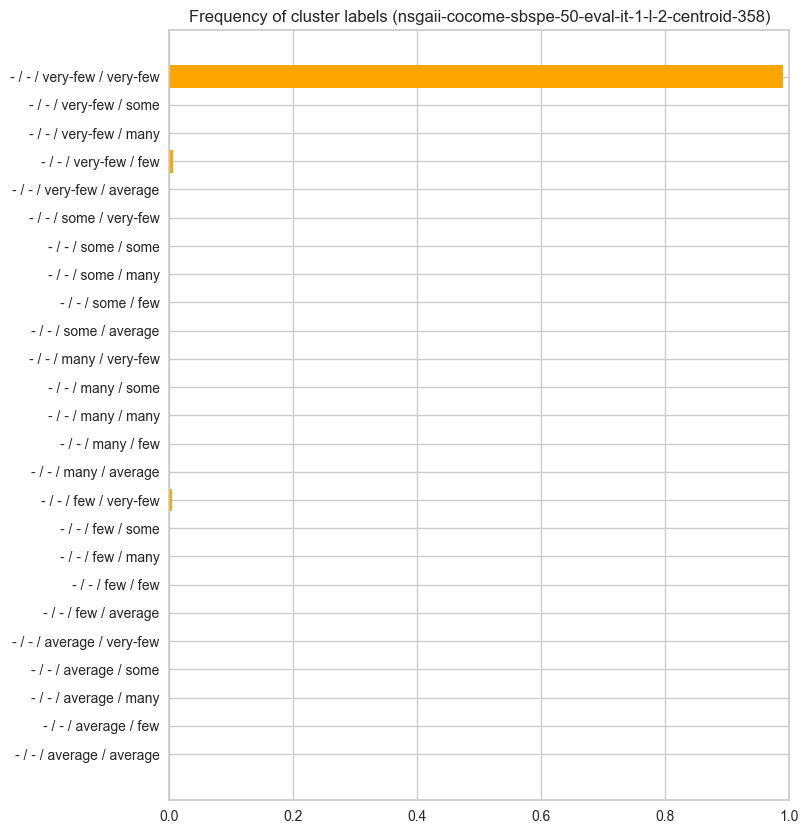

{'- / - / average / average': 0.0,
 '- / - / average / few': 0.0,
 '- / - / average / many': 0.0,
 '- / - / average / some': 0.0,
 '- / - / average / very-few': 0.0,
 '- / - / few / average': 0.0,
 '- / - / few / few': 0.0,
 '- / - / few / many': 0.0,
 '- / - / few / some': 0.0,
 '- / - / few / very-few': 0.004032258064516129,
 '- / - / many / average': 0.0,
 '- / - / many / few': 0.0,
 '- / - / many / many': 0.0,
 '- / - / many / some': 0.0,
 '- / - / many / very-few': 0.0,
 '- / - / some / average': 0.0,
 '- / - / some / few': 0.0,
 '- / - / some / many': 0.0,
 '- / - / some / some': 0.0,
 '- / - / some / very-few': 0.0,
 '- / - / very-few / average': 0.0,
 '- / - / very-few / few': 0.006048387096774193,
 '- / - / very-few / many': 0.0,
 '- / - / very-few / some': 0.0,
 '- / - / very-few / very-few': 0.9899193548387096}

In [121]:
it1_50_c358_space.show_cluster_labels_distribution(size=(8,10))

### *Visualization (density)*

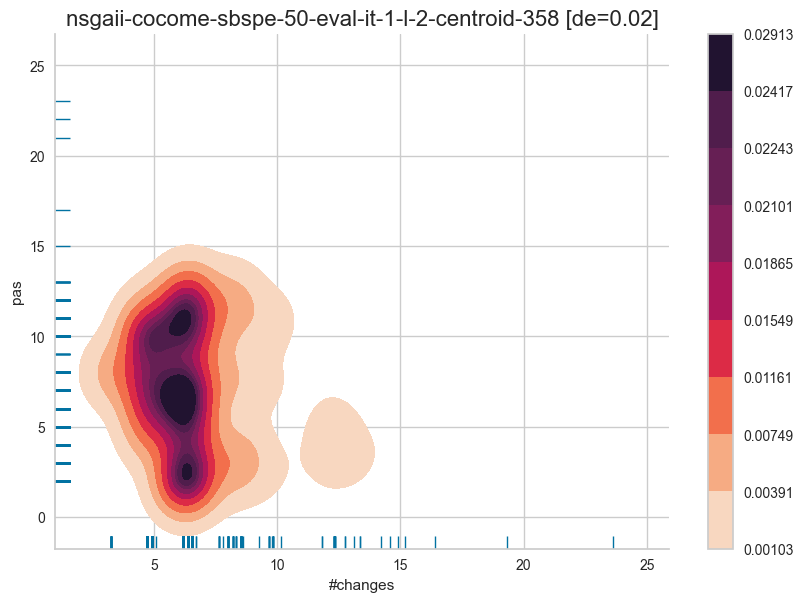

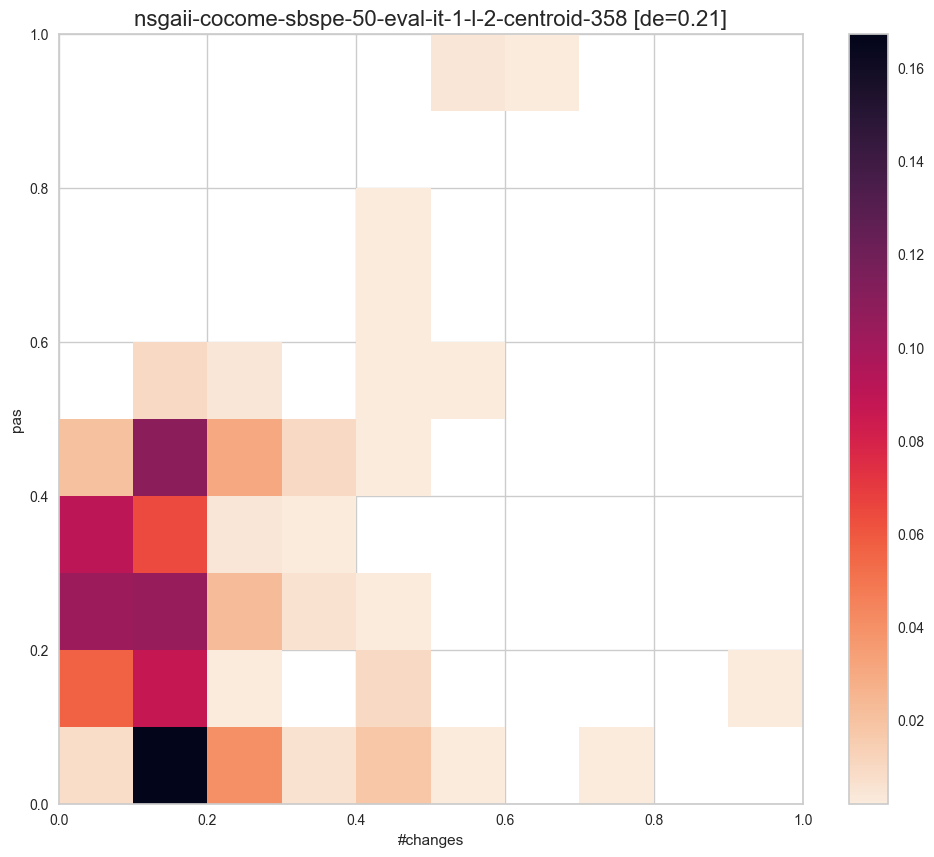

In [122]:
# Density plots for the 2D space of changes versus pas
it1_50_c358_space.show_density_plot(objectives=OBJS_CHANGES_PAS, normalize=False) 
it1_50_c358_space.show_density_plot(kind='bins', objectives=OBJS_CHANGES_PAS, normalize=True, bins=10) 

In [123]:
# Entropy of 2D space
de_2D = it1_50_c358_space.compute_density_entropy(normalize=True, bins=10)
print("The density entropy is:", de_2D)

The density entropy is: 0.20691512672356185


---
## **Iteration 0 (non-interactive, 100)**

In [124]:
# Initialize the project/file
it0_100_space = ArchitectureSpaceAnalyzer(objectives=OBJS_CHANGES_PAS)
it0_100_space.initialize_dataset(NSGAII_IT0_100_PROJECT_NAME)
print(it0_100_space.PROJECT_NAME)

it0_100_space.set_labels(ALL_CLUSTER_LABELS)
it0_100_space.CHANGES_LIMITS = CHANGES_LIMITS
it0_100_space.PAS_LIMITS = PAS_LIMITS

# Read all the objectives and refactoring actions
# Note that length of sequences is 4
_ = it0_100_space.read_file_batch(1,31, length=4, arguments=0, option='all')

project: nsgaii-cocome-sbspe-100-eval-it-0
objective files= 31
refactoring actions files= 31
nsgaii-cocome-sbspe-100-eval-it-0
Reading files ... 1 31 all
  file 0
  file 1
  file 2
  file 3
  file 4
  file 5
  file 6
  file 7
  file 8
  file 9
  file 10
  file 11
  file 12
  file 13
  file 14
  file 15
  file 16
  file 17
  file 18
  file 19
  file 20
  file 21
  file 22
  file 23
  file 24
  file 25
  file 26
  file 27
  file 28
  file 29
  file 30
done.


In [125]:
it0_100_space.objectives_df.head()

solID     perfQ  reliability  #changes   pas
0    948  0.126520     0.650817      5.99   2.0
1   1030  0.244533     0.682525      4.35   7.0
2   2351  0.082578     0.940504      6.18   2.0
3   2736  0.381278     0.831799     36.86  16.0
4   2749  0.381278     0.831799     36.86  16.0

Statistics for changes and pas objectives.

In [126]:
it0_100_space.objectives_df[OBJS_CHANGES_PAS].describe()

#changes         pas
count  491.000000  491.000000
mean    11.601446    9.788187
std      8.597744    7.253707
min      2.900000    0.000000
25%      5.990000    4.500000
50%      8.140000    8.000000
75%     15.145000   12.000000
max     51.800000   41.000000

In [127]:
#it0_100_space.refactions_df.head()

### *Metrics*

In [128]:
ref100_it0_pf = it0_100_space.get_pareto_front()
#ref100_it0_norm_pf = it0_100_space.compute_pareto_front(invert_max=True, objectives=objs_changes_pas)

# The reference front is the ref1000 space
metrics100_it0_dict = it0_100_space.compute_all_metrics(ref_point=(1,1), reference_front=ref1000_norm_pf)
metrics100_it0_dict['point'] = 'it-01-baseline'
print("Pareto front metrics (#changes versus pas):")
print(metrics100_it0_dict)

ref100_it0_pf.head()

Pareto front metrics (#changes versus pas):
{'C_AB': 0.23076923076923078, 'C_BA': 0.9473684210526315, 'IGDPlus': 0.04036559874061712, 'HV': 0.9952616090578084, 'NPS': 19, 'NSolutions': 302, 'NSequences': 489, 'DE': 0.43764153736628997, 'point': 'it-01-baseline'}


#changes  pas
0      3.09  2.0
1      4.35  2.0
2      4.54  2.0
3      4.73  2.0
4      6.53  1.0

In [129]:
complete_pf = ref100_it0_pf.merge(it0_100_space.objectives_df, on=OBJS_CHANGES_PAS)
complete_pf = complete_pf.drop_duplicates(subset=PROBLEM_OBJECTIVES)
print(complete_pf.shape)
complete_pf.to_csv('./datasets/it0_100_pf.csv', index=False)
#ref100_it0_pf.merge(it0_100_space.objectives_df, on=OBJS_CHANGES_PAS).to_csv('it0_100_pf.csv', index=False)

it0_100_space.objectives_df.drop_duplicates(subset=PROBLEM_OBJECTIVES).to_csv('./datasets/it0_100.csv', index=False)

(40, 5)


### *Clustering*
This is not strictly needed for the RQ, but it is for computing the scatter plot below.

In [130]:
# Try k-Means
#labels, _, silhouette = it0_100_space.run_kmeans(k=5, show_silhouette=False) 

# Try agglomerative clustering
labels, _, silhouette = it0_100_space.run_agglomerative(k=5, threshold=None, show_dendogram=False) 
it0_100_space.assign_cluster_labels(labels) # This effectively assigns the labels

Number of clusters = 5
Labels for instances: [2 4 2 1 1 4 2 2 2 4 2 4 2 2 4 4 4 4 4 2 4 0 0 4 4 4 4 4 4 2 0 4 0 3 1 4 4
 4 0 1 2 4 0 2 4 4 2 4 0 2 0 4 4 2 2 0 4 4 4 1 2 0 0 4 1 0 1 4 4 1 2 4 0 1
 0 4 2 4 4 4 0 4 4 1 1 1 0 0 4 4 4 4 2 4 0 1 4 4 4 4 1 2 0 0 0 0 0 4 4 2 2
 4 4 4 4 4 4 4 4 2 2 4 4 4 2 4 2 2 4 0 2 2 4 4 4 2 2 2 4 3 3 4 2 4 4 4 0 4
 4 4 4 2 4 2 2 4 2 4 4 4 2 2 4 4 4 4 4 2 4 4 2 1 2 4 2 4 2 4 0 0 4 0 4 0 4
 4 4 1 1 4 2 2 0 4 2 4 0 4 4 4 4 4 4 0 2 0 1 0 3 2 3 1 0 1 4 0 0 2 4 2 1 2
 4 2 2 2 2 2 4 0 0 2 4 0 2 0 1 1 1 1 4 2 2 0 4 4 4 0 4 0 2 1 2 1 4 4 0 0 0
 4 0 0 2 4 4 2 4 4 2 0 2 0 2 1 2 3 3 3 1 3 4 0 0 4 2 4 0 4 4 2 4 2 0 0 4 0
 0 2 4 4 0 0 4 4 0 0 2 4 4 0 2 4 4 4 2 4 0 0 2 4 4 0 0 4 2 0 0 0 0 0 0 4 2
 2 4 2 4 0 4 0 4 0 4 2 4 2 4 4 4 2 4 4 0 0 4 0 4 2 2 4 2 2 4 4 2 4 4 0 0 0
 0 0 0 0 4 0 4 4 2 2 4 2 0 0 0 4 0 4 4 0 0 4 4 4 2 2 4 4 4 4 0 1 4 2 2 2 2
 2 4 4 4 2 4 4 2 4 0 0 0 4 4 2 2 4 4 2 4 2 4 2 2 4 3 4 2 4 0 0 0 2 0 4 4 4
 2 0 4 0 2 1 2 0 0 4 4 4 4 2 2 2 4 1 3 4 0 0 2 3 3 3 4 

perfQ  reliability  #changes   pas  cluster  \
367  0.436996     0.065948     15.96  14.0        0   
84   0.424976    -0.211405     28.77  24.0        1   
194  0.304655     0.352881      8.33   3.0        2   
139  0.431055     0.066262     43.06  34.0        3   
486  0.068764     0.575803      6.34   8.0        4   

                           label  
367  - / - / very-few / very-few  
84             - / - / few / few  
194  - / - / very-few / very-few  
139        - / - / average / few  
486  - / - / very-few / very-few

In [131]:
it0_100_space.show_scatter_plot(x='#changes', y='pas', show_all_labels=True)
#it0_100_space.show_petal_plot(labels=True, size=(20,5))

Using alternatives as prototypes ... []


alt.HConcatChart(...)

In [132]:
it0_100_space.show_scatter_plot(x='#changes', y='pas', show_all_labels=True, pfonly=True)

Using alternatives as prototypes ... []


alt.HConcatChart(...)

In [133]:
it0_100_space.clusters_info()

  cluster 4 : 208 items 42.36 % - / - / very-few / very-few
  cluster 2 : 123 items 25.05 % - / - / very-few / very-few
  cluster 0 : 111 items 22.61 % - / - / very-few / very-few
  cluster 1 : 35 items 7.13 % - / - / few / few
  cluster 3 : 14 items 2.85 % - / - / average / few


In [134]:
it0_100_space.describe_cluster_labels(objectives=OBJS_CHANGES_PAS)

Using predefined limits (0, 1.0)
Using predefined limits (1, 84)
Using predefined limits (0, 86)
Using predefined limits (0, 1.0)


objective    min    max  unit     label
5   #changes   0.90  17.54  unit  very-few
6   #changes  17.54  34.18  unit       few
7   #changes  34.18  50.82  unit   average
8   #changes  50.82  67.46  unit      some
9   #changes  67.46  84.10  unit      many
10       pas  -0.10  17.14  unit  very-few
11       pas  17.14  34.38  unit       few
12       pas  34.38  51.62  unit   average
13       pas  51.62  68.86  unit      some
14       pas  68.86  86.10  unit      many

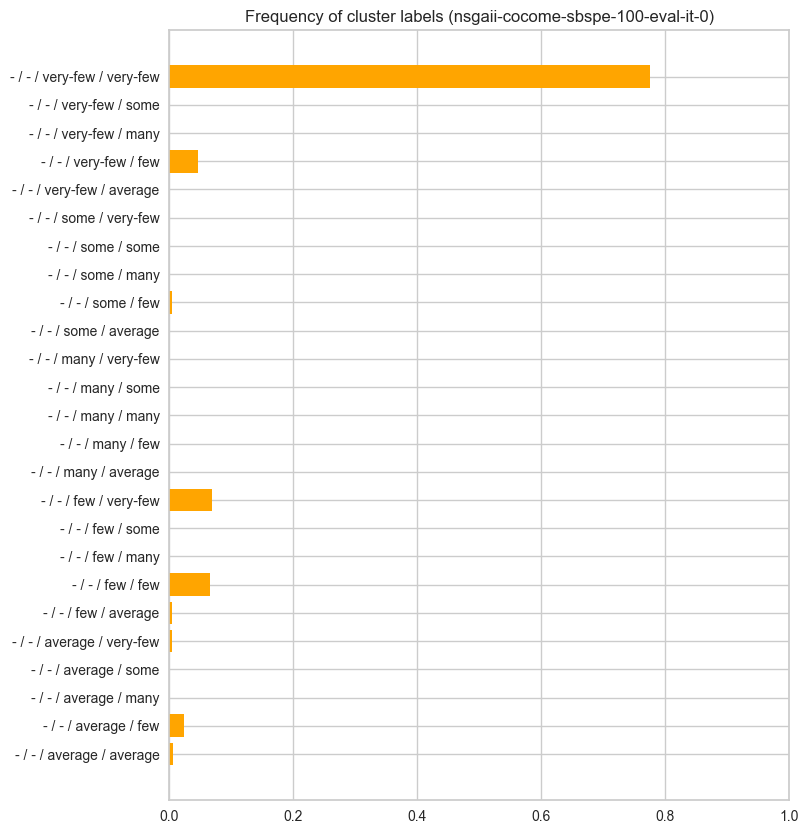

{'- / - / average / average': 0.006109979633401222,
 '- / - / average / few': 0.024439918533604887,
 '- / - / average / many': 0.0,
 '- / - / average / some': 0.0,
 '- / - / average / very-few': 0.004073319755600814,
 '- / - / few / average': 0.004073319755600814,
 '- / - / few / few': 0.06517311608961303,
 '- / - / few / many': 0.0,
 '- / - / few / some': 0.0,
 '- / - / few / very-few': 0.06924643584521385,
 '- / - / many / average': 0.0,
 '- / - / many / few': 0.0,
 '- / - / many / many': 0.0,
 '- / - / many / some': 0.0,
 '- / - / many / very-few': 0.0,
 '- / - / some / average': 0.0,
 '- / - / some / few': 0.004073319755600814,
 '- / - / some / many': 0.0,
 '- / - / some / some': 0.0,
 '- / - / some / very-few': 0.0,
 '- / - / very-few / average': 0.0,
 '- / - / very-few / few': 0.04684317718940937,
 '- / - / very-few / many': 0.0,
 '- / - / very-few / some': 0.0,
 '- / - / very-few / very-few': 0.7759674134419552}

In [135]:
it0_100_space.show_cluster_labels_distribution(size=(8,10))

### *Visualizations (density)*

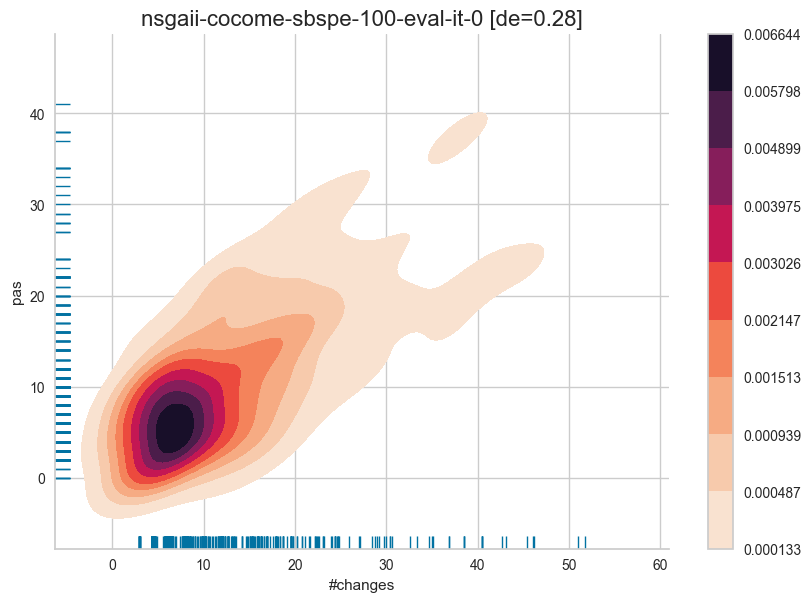

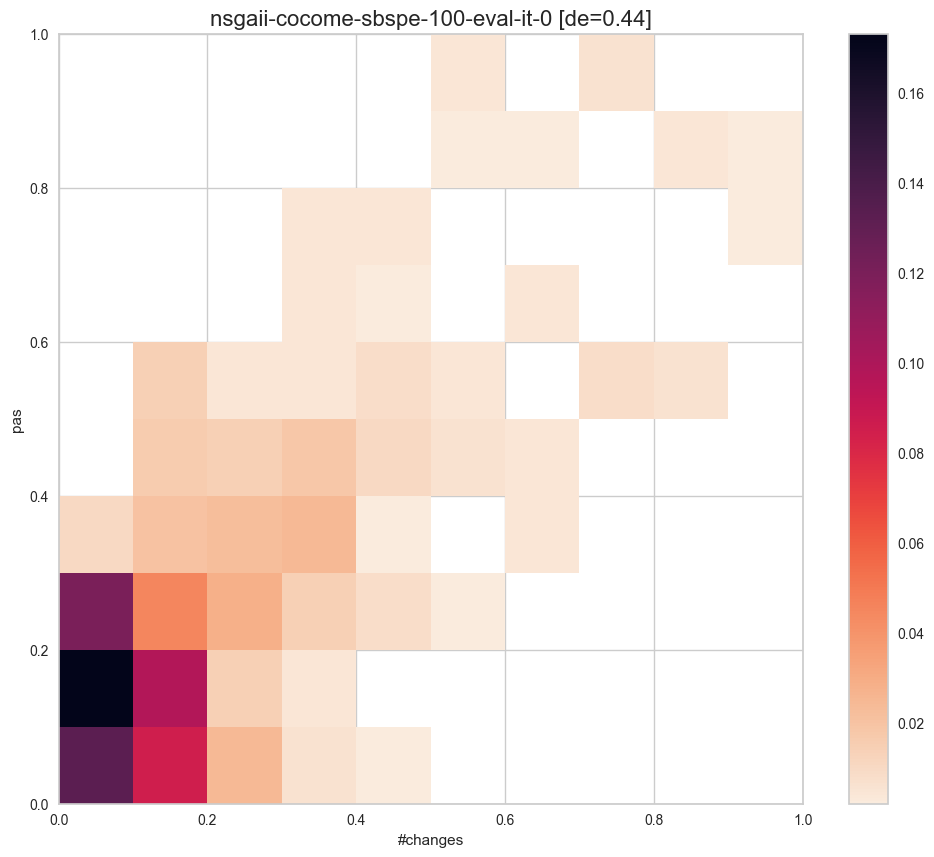

In [136]:
# Density plots for the 2D space of changes versus pas
it0_100_space.show_density_plot(objectives=OBJS_CHANGES_PAS, normalize=False) 
it0_100_space.show_density_plot(kind='bins', objectives=OBJS_CHANGES_PAS, normalize=True, bins=10) 

In [137]:
# Entropy of 2D space
de_2D = it0_100_space.compute_density_entropy(normalize=True, bins=10)
print("The density entropy is:", de_2D)

The density entropy is: 0.43764153736628997


---

## **Misc**

### *Comparison of Metrics*

In [138]:
# Concatenation of all the metrics
s1 = pd.DataFrame([metrics1000_dict])
#s2 = pd.DataFrame([metrics50_it0_dict])
s3 = pd.DataFrame([metrics50_it1_c317_dict])
s4 = pd.DataFrame([metrics50_it1_c358_dict])
s5 = pd.DataFrame([metrics100_it0_dict])
metrics_df = pd.concat([s1, s3, s4, s5])
metrics_df

C_AB      C_BA   IGDPlus        HV  NPS  NSolutions  NSequences  \
0  1.000000  1.000000  0.000000  0.997740   13         324         492   
0  0.230769  1.000000  0.091508  0.973310    9          97         461   
0  0.153846  1.000000  0.062257  0.971925   13          95         463   
0  0.230769  0.947368  0.040366  0.995262   19         302         489   

         DE           point  
0  0.607195       reference  
0  0.258559        it1-c317  
0  0.206915        it1-c358  
0  0.437642  it-01-baseline

In [139]:
#dfi.export(metrics_df,'table.png', table_conversion = 'matplotlib')
#Image.open('table.png')

In [140]:
# Looking at the different cluster labels from all the spaces
a = set(ref1000_space.CLUSTER_LABELS.values())
b = set(it0_50_space.CLUSTER_LABELS.values())
c = set(it1_50_c317_space.CLUSTER_LABELS.values())
d = set(it1_50_c358_space.CLUSTER_LABELS.values())
e = set(it0_100_space.CLUSTER_LABELS.values())

ALL_CLUSTER_LABELS = a.union(b,c,d,e)
print(len(ALL_CLUSTER_LABELS)) 
list(ALL_CLUSTER_LABELS)

6


['- / - / average / average',
 '- / - / few / few',
 '- / - / average / few',
 '- / - / some / many',
 '- / - / very-few / very-few',
 '- / - / very-few / few']

In [141]:
a = set(ref1000_space.tagged_objectives_df['label'])
b = set(it0_50_space.tagged_objectives_df['label'])
c = set(it1_50_c317_space.tagged_objectives_df['label'])
d = set(it1_50_c358_space.tagged_objectives_df['label'])
e = set(it0_100_space.tagged_objectives_df['label'])

ALL_CLUSTER_LABELS = a.union(b,c,d,e)
print(len(ALL_CLUSTER_LABELS)) 
list(ALL_CLUSTER_LABELS)

18


['- / - / average / average',
 '- / - / very-few / very-few',
 '- / - / average / many',
 '- / - / many / many',
 '- / - / very-few / few',
 '- / - / average / very-few',
 '- / - / many / some',
 '- / - / some / few',
 '- / - / average / some',
 '- / - / few / few',
 '- / - / average / few',
 '- / - / many / average',
 '- / - / some / some',
 '- / - / some / many',
 '- / - / some / average',
 '- / - / few / average',
 '- / - / few / some',
 '- / - / few / very-few']

In [142]:
c1_max = ref1000_space.objectives_df['#changes'].max()
c2_max = it0_50_space.objectives_df['#changes'].max()
c3_max = it1_50_c317_space.objectives_df['#changes'].max()
c4_max = it1_50_c358_space.objectives_df['#changes'].max()
c5_max = it0_100_space.objectives_df['#changes'].max()
max_changes = max([c1_max,c2_max,c3_max,c4_max,c4_max])
print('max #changes=', max_changes)

max #changes= 82.94000000000004


In [143]:
c1_min = ref1000_space.objectives_df['#changes'].min()
c2_min = it0_50_space.objectives_df['#changes'].min()
c3_min = it1_50_c317_space.objectives_df['#changes'].min()
c4_min = it1_50_c358_space.objectives_df['#changes'].min()
c5_min = it0_100_space.objectives_df['#changes'].min()
min_changes = min([c1_min,c2_min,c3_min,c4_min,c5_min])
print('main #changes=', min_changes)

main #changes= 1.45


In [144]:
p1_max = ref1000_space.objectives_df['pas'].max()
p2_max = it0_50_space.objectives_df['pas'].max()
p3_max = it1_50_c317_space.objectives_df['pas'].max()
p4_max = it1_50_c358_space.objectives_df['pas'].max()
p5_max = it0_100_space.objectives_df['pas'].max()
max_pas = max([p1_max,p2_max,p3_max,p4_max,p5_max])
print('max #pas=', max_pas)

max #pas= 86.0


In [145]:
p1_min = ref1000_space.objectives_df['pas'].min()
p2_min = it0_50_space.objectives_df['pas'].min()
p3_min = it1_50_c317_space.objectives_df['pas'].min()
p4_min = it1_50_c358_space.objectives_df['pas'].min()
p5_min = it0_100_space.objectives_df['pas'].min()
min_pas = min([p1_min,p2_min,p3_min,p4_min,p5_min])
print('min #pas=', min_pas)

min #pas= 0.0


# **ANALYSIS OF REFACTORING SPACES**

## **Reference Pareto Front** (1000)
These are types of refactoring actions (without their arguments)

In [146]:
ref1000_space.refactions_df.head() 

solID                                    op1  \
0  17566                Move_Component_New_Node   
1  17811               Move_Operation_Component   
2  22051               Move_Operation_Component   
3  22521               Move_Operation_Component   
4  22660  Move_Operation_New_Component_New_Node   

                                     op2  \
0                Move_Component_New_Node   
1  Move_Operation_New_Component_New_Node   
2  Move_Operation_New_Component_New_Node   
3  Move_Operation_New_Component_New_Node   
4                Move_Component_New_Node   

                                     op3                       op4  
0  Move_Operation_New_Component_New_Node   Move_Component_New_Node  
1  Move_Operation_New_Component_New_Node  Move_Operation_Component  
2               Move_Operation_Component  Move_Operation_Component  
3                Move_Component_New_Node  Move_Operation_Component  
4  Move_Operation_New_Component_New_Node  Move_Operation_Component

In [147]:
operations_ref1000 = ref1000_space.get_candidate_operations()
#print(len(operations_ref1000), operations_ref1000)

refactions: 492
all operations: 1968


refactions: 492
all operations: 1968


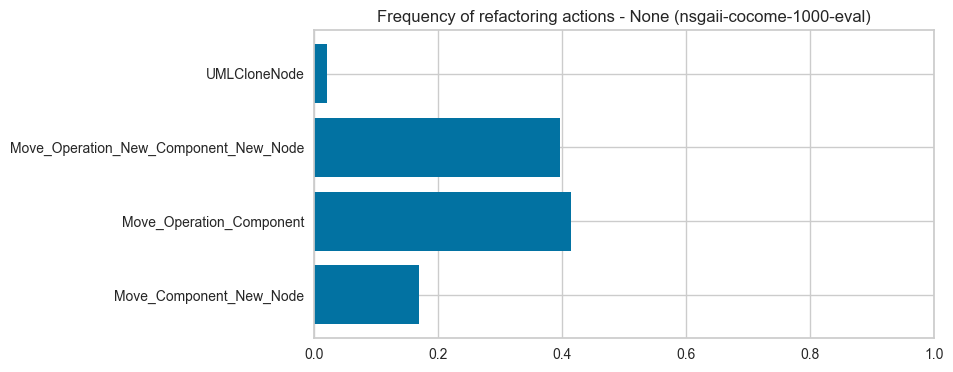

(array(['Move_Component_New_Node', 'Move_Operation_Component',
        'Move_Operation_New_Component_New_Node', 'UMLCloneNode'],
       dtype='<U37'),
 array([0.16869919, 0.41412602, 0.39634146, 0.02083333]))

In [148]:
ref1000_space.show_refactions_distribution(size=(8,4), normalize=True)

refactions: 492
all operations: 492
refactions: 492
all operations: 492
refactions: 492
all operations: 492
refactions: 492
all operations: 492


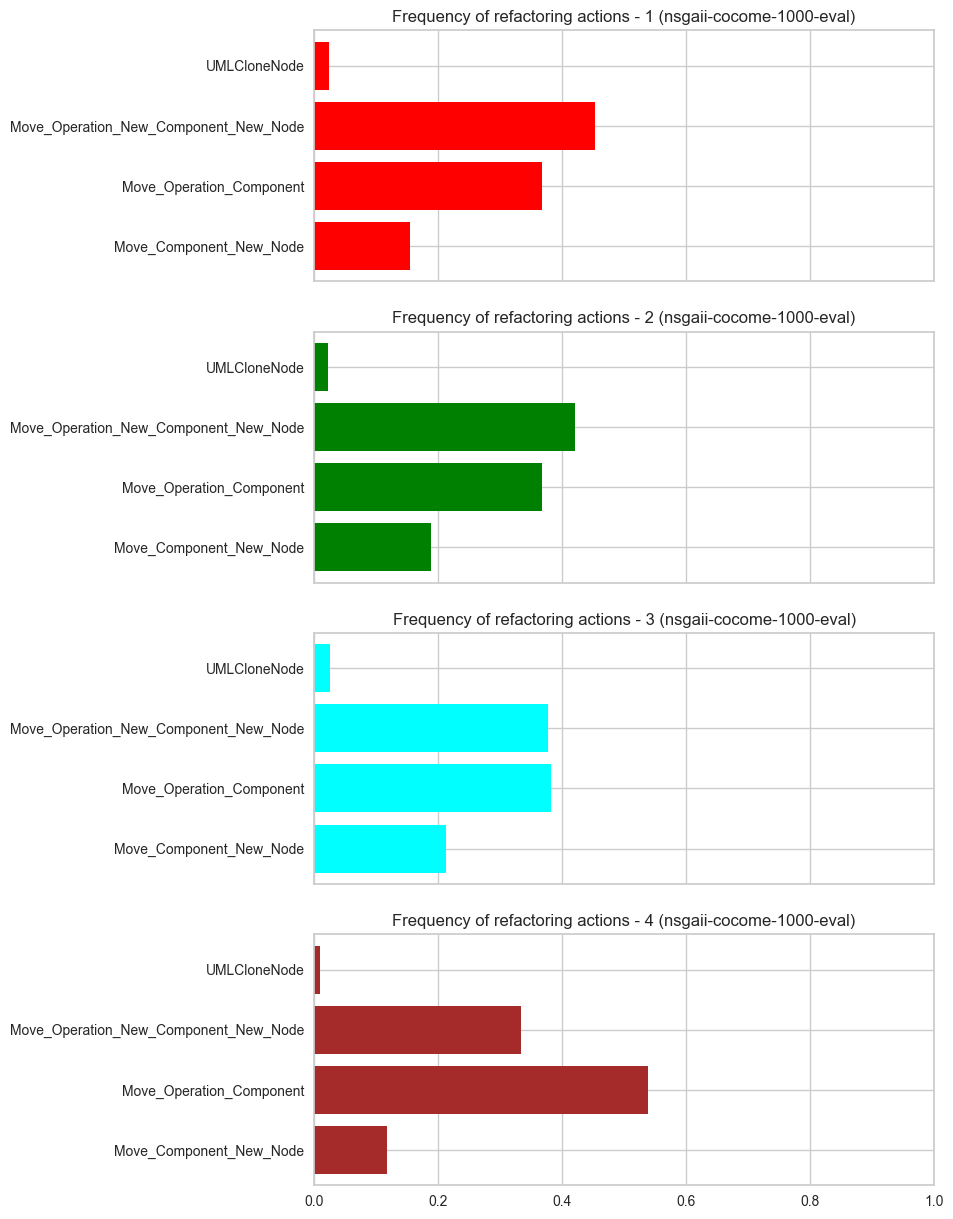

([array(['Move_Component_New_Node', 'Move_Operation_Component',
         'Move_Operation_New_Component_New_Node', 'UMLCloneNode'],
        dtype='<U37'),
  array(['Move_Component_New_Node', 'Move_Operation_Component',
         'Move_Operation_New_Component_New_Node', 'UMLCloneNode'],
        dtype='<U37'),
  array(['Move_Component_New_Node', 'Move_Operation_Component',
         'Move_Operation_New_Component_New_Node', 'UMLCloneNode'],
        dtype='<U37'),
  array(['Move_Component_New_Node', 'Move_Operation_Component',
         'Move_Operation_New_Component_New_Node', 'UMLCloneNode'],
        dtype='<U37')],
 [array([0.15447154, 0.36788618, 0.45325203, 0.02439024]),
  array([0.18902439, 0.36788618, 0.42073171, 0.02235772]),
  array([0.21341463, 0.38211382, 0.37804878, 0.02642276]),
  array([0.11788618, 0.53861789, 0.33333333, 0.0101626 ])])

In [149]:
ref1000_space.show_refactions_distribution(size=(8,15), option=0, normalize=True)

## **Iteration 1: Centroid 317** (interactive, 50)

In [150]:
it1_50_c317_space.refactions_df.head()

solID                                    op1  \
0    148               Move_Operation_Component   
1    342               Move_Operation_Component   
2    354               Move_Operation_Component   
3    733  Move_Operation_New_Component_New_Node   
4   1077                Move_Component_New_Node   

                                     op2  
0                Move_Component_New_Node  
1  Move_Operation_New_Component_New_Node  
2  Move_Operation_New_Component_New_Node  
3  Move_Operation_New_Component_New_Node  
4               Move_Operation_Component

In [151]:
# centroid 317 --> solID = 1419
it0_50_space.refactions_df[it0_50_space.refactions_df.solID == 1419]
# Move_Operation_Component	Move_Operation_Component

solID                       op1                                    op2
239   1419  Move_Operation_Component  Move_Operation_New_Component_New_Node
317   1419  Move_Operation_Component               Move_Operation_Component
346   1419              UMLCloneNode               Move_Operation_Component
471   1419  Move_Operation_Component               Move_Operation_Component

In [152]:
#prefix_sequence_centroid317_2args = ['Move_Operation_Component(??,??)',	'Move_Operation_Component(??,??)']
prefix_sequence_centroid317 = ['Move_Operation_Component',	'Move_Operation_Component']
it1_50_c317_space.add_sequence_prefix(prefix_sequence_centroid317).head()

solID                       op1                       op2  \
0    148  Move_Operation_Component  Move_Operation_Component   
1    342  Move_Operation_Component  Move_Operation_Component   
2    354  Move_Operation_Component  Move_Operation_Component   
3    733  Move_Operation_Component  Move_Operation_Component   
4   1077  Move_Operation_Component  Move_Operation_Component   

                                     op3  \
0               Move_Operation_Component   
1               Move_Operation_Component   
2               Move_Operation_Component   
3  Move_Operation_New_Component_New_Node   
4                Move_Component_New_Node   

                                     op4  
0                Move_Component_New_Node  
1  Move_Operation_New_Component_New_Node  
2  Move_Operation_New_Component_New_Node  
3  Move_Operation_New_Component_New_Node  
4               Move_Operation_Component

In [153]:
operations_centroid317 = it1_50_c317_space.get_candidate_operations()
#print(len(operations_centroid317), operations_centroid317)

refactions: 495
all operations: 1980


refactions: 495
all operations: 1980


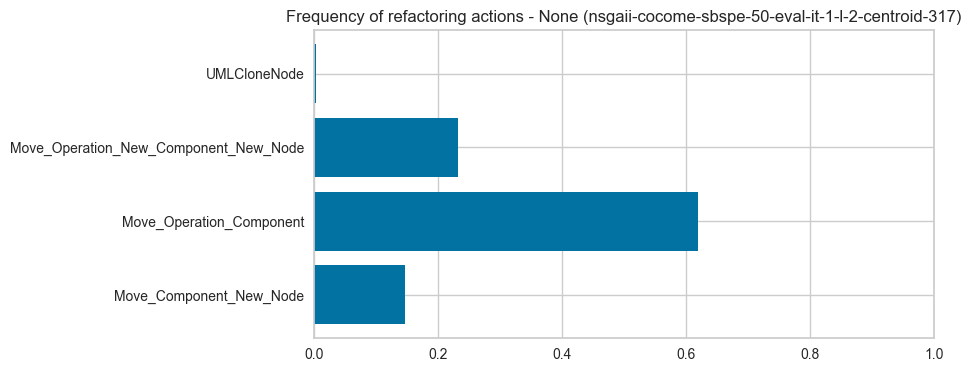

(array(['Move_Component_New_Node', 'Move_Operation_Component',
        'Move_Operation_New_Component_New_Node', 'UMLCloneNode'],
       dtype='<U37'),
 array([0.1459596 , 0.61868687, 0.23282828, 0.00252525]))

In [154]:
it1_50_c317_space.show_refactions_distribution(size=(8,4), normalize=True)

refactions: 495
all operations: 495
refactions: 495
all operations: 495
refactions: 495
all operations: 495
refactions: 495
all operations: 495


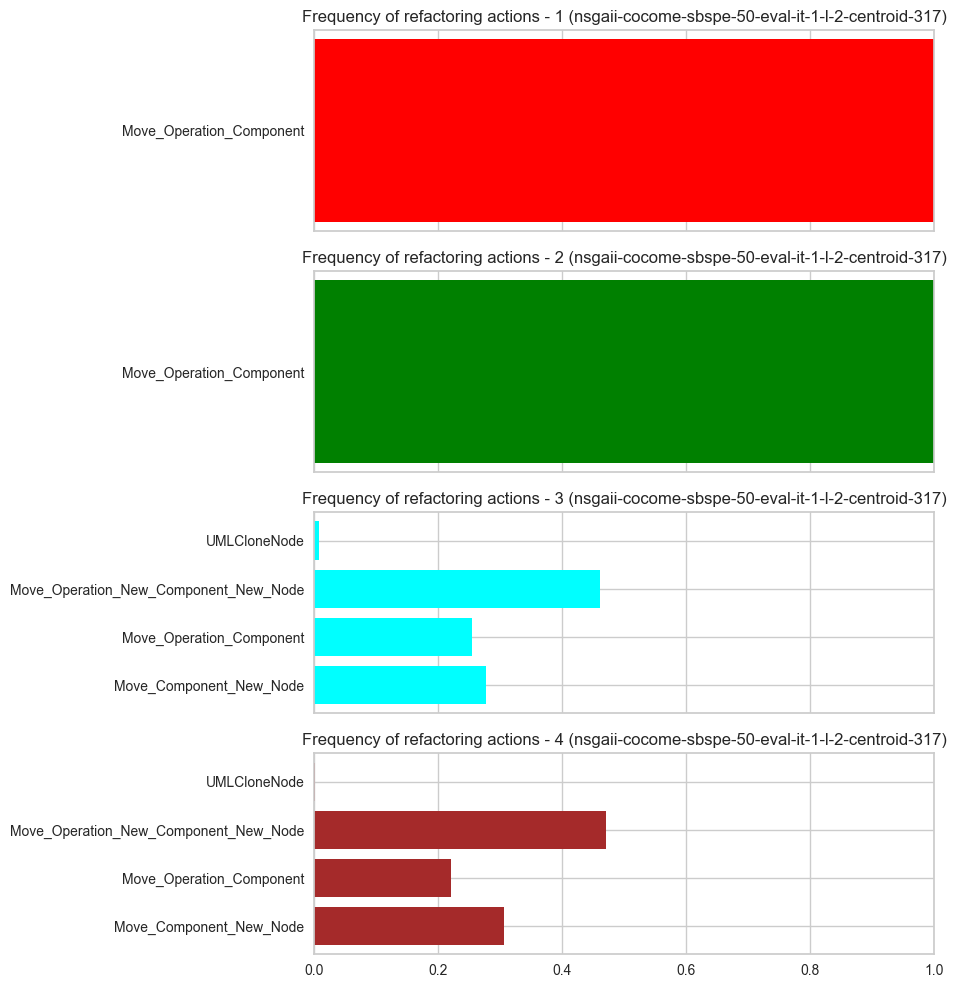

([array(['Move_Operation_Component'], dtype='<U24'),
  array(['Move_Operation_Component'], dtype='<U24'),
  array(['Move_Component_New_Node', 'Move_Operation_Component',
         'Move_Operation_New_Component_New_Node', 'UMLCloneNode'],
        dtype='<U37'),
  array(['Move_Component_New_Node', 'Move_Operation_Component',
         'Move_Operation_New_Component_New_Node', 'UMLCloneNode'],
        dtype='<U37')],
 [array([1.]),
  array([1.]),
  array([0.27676768, 0.25454545, 0.46060606, 0.00808081]),
  array([0.30707071, 0.22020202, 0.47070707, 0.0020202 ])])

In [155]:
countops_it1_50_c317 = it1_50_c317_space.show_refactions_distribution(size=(8,12), option=0, normalize=True)
countops_it1_50_c317

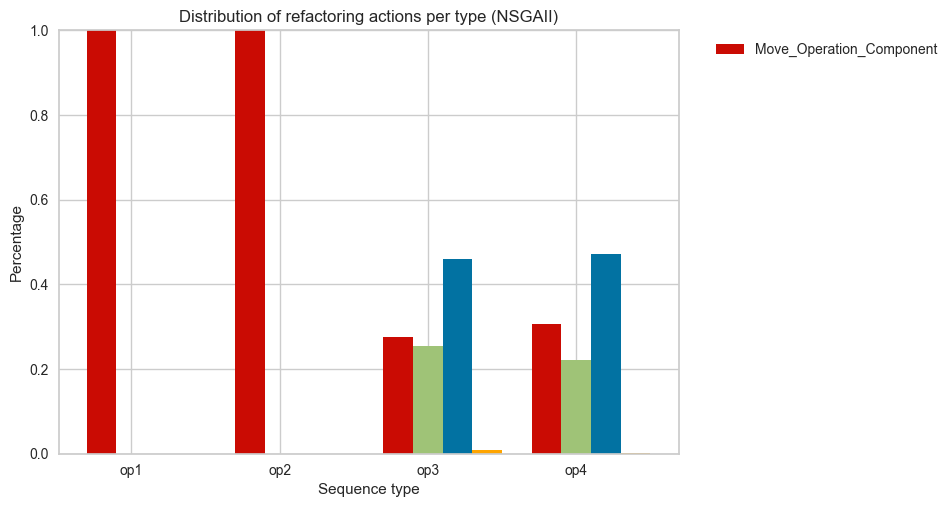

In [156]:
_ = it1_50_c317_space.plot_barchart_group(countops_it1_50_c317, title='(NSGAII)')

## **Iteration 1: Centroid 358 (interactive, 50)**

In [157]:
it1_50_c358_space.refactions_df.head()

solID                                    op1  \
0    145               Move_Operation_Component   
1    155  Move_Operation_New_Component_New_Node   
2    463  Move_Operation_New_Component_New_Node   
3    509                Move_Component_New_Node   
4    534  Move_Operation_New_Component_New_Node   

                                     op2  
0  Move_Operation_New_Component_New_Node  
1               Move_Operation_Component  
2  Move_Operation_New_Component_New_Node  
3  Move_Operation_New_Component_New_Node  
4  Move_Operation_New_Component_New_Node

In [158]:
# centroid 358 --> solID = 584 
it0_50_space.refactions_df[it0_50_space.refactions_df.solID == 838]
# Move_Operation_Component	Move_Operation_Component

solID                       op1                       op2
358    838  Move_Operation_Component  Move_Operation_Component

In [159]:
prefix_sequence_centroid358 = ['Move_Operation_Component',	'Move_Operation_Component']
it1_50_c358_space.add_sequence_prefix(prefix_sequence_centroid358).head()

solID                       op1                       op2  \
0    145  Move_Operation_Component  Move_Operation_Component   
1    155  Move_Operation_Component  Move_Operation_Component   
2    463  Move_Operation_Component  Move_Operation_Component   
3    509  Move_Operation_Component  Move_Operation_Component   
4    534  Move_Operation_Component  Move_Operation_Component   

                                     op3  \
0               Move_Operation_Component   
1  Move_Operation_New_Component_New_Node   
2  Move_Operation_New_Component_New_Node   
3                Move_Component_New_Node   
4  Move_Operation_New_Component_New_Node   

                                     op4  
0  Move_Operation_New_Component_New_Node  
1               Move_Operation_Component  
2  Move_Operation_New_Component_New_Node  
3  Move_Operation_New_Component_New_Node  
4  Move_Operation_New_Component_New_Node

In [160]:
operations_centroid358 = it1_50_c358_space.get_candidate_operations()
#print(len(operations_centroid358), operations_centroid358)

refactions: 496
all operations: 1984


refactions: 496
all operations: 1984


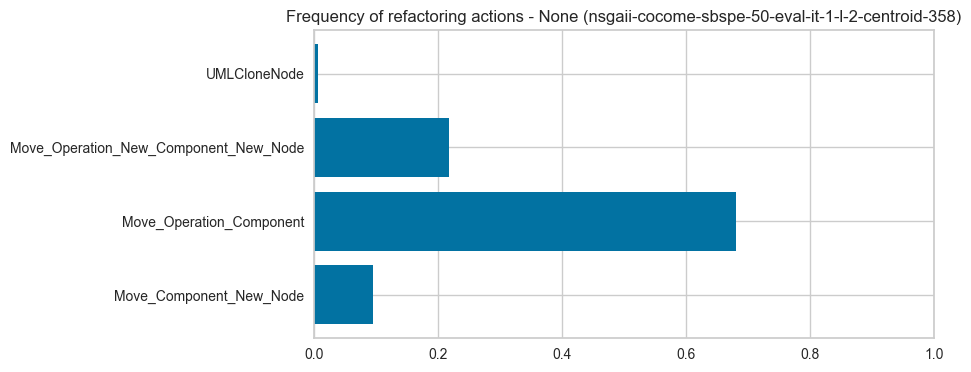

(array(['Move_Component_New_Node', 'Move_Operation_Component',
        'Move_Operation_New_Component_New_Node', 'UMLCloneNode'],
       dtype='<U37'),
 array([0.09475806, 0.68094758, 0.21824597, 0.00604839]))

In [161]:
it1_50_c358_space.show_refactions_distribution(size=(8,4), normalize=True)

refactions: 496
all operations: 496
refactions: 496
all operations: 496
refactions: 496
all operations: 496
refactions: 496
all operations: 496


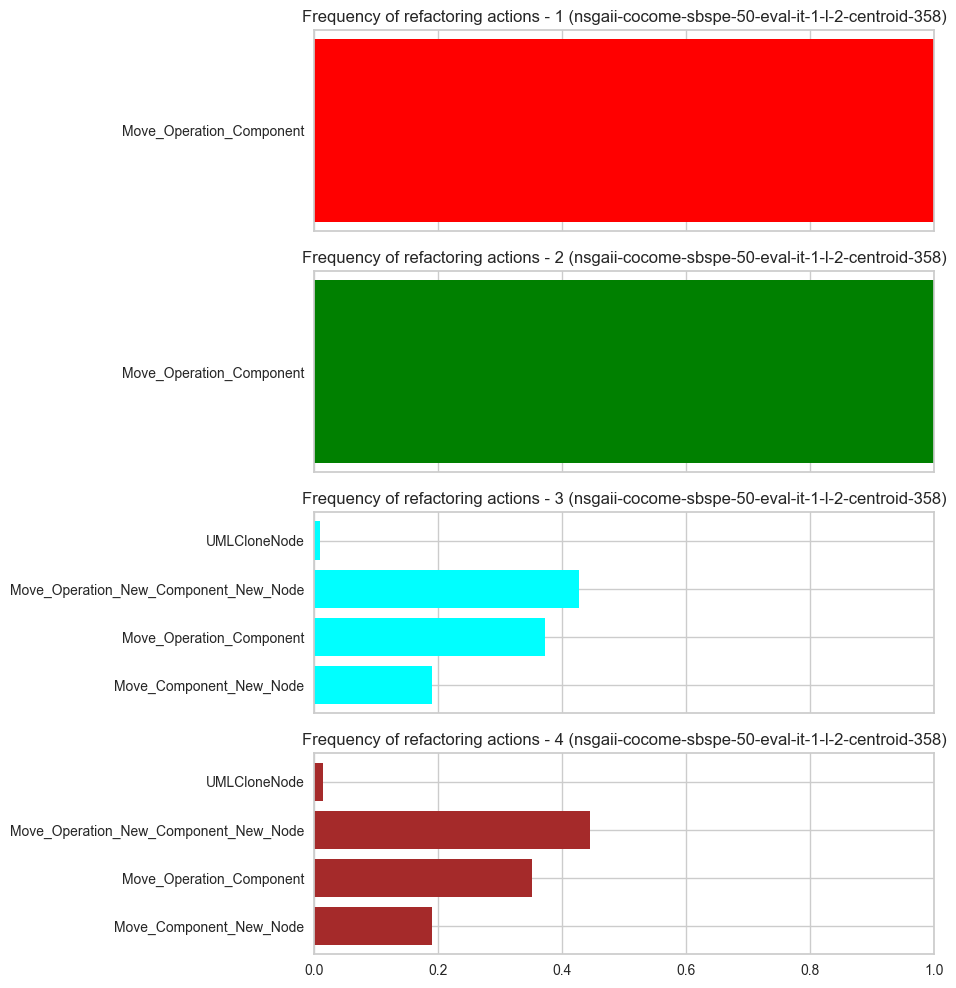

([array(['Move_Operation_Component'], dtype='<U24'),
  array(['Move_Operation_Component'], dtype='<U24'),
  array(['Move_Component_New_Node', 'Move_Operation_Component',
         'Move_Operation_New_Component_New_Node', 'UMLCloneNode'],
        dtype='<U37'),
  array(['Move_Component_New_Node', 'Move_Operation_Component',
         'Move_Operation_New_Component_New_Node', 'UMLCloneNode'],
        dtype='<U37')],
 [array([1.]),
  array([1.]),
  array([0.18951613, 0.37298387, 0.42741935, 0.01008065]),
  array([0.18951613, 0.35080645, 0.44556452, 0.0141129 ])])

In [162]:
countops_it1_50_c358 = it1_50_c358_space.show_refactions_distribution(size=(8,12), option=0, normalize=True)
countops_it1_50_c358 

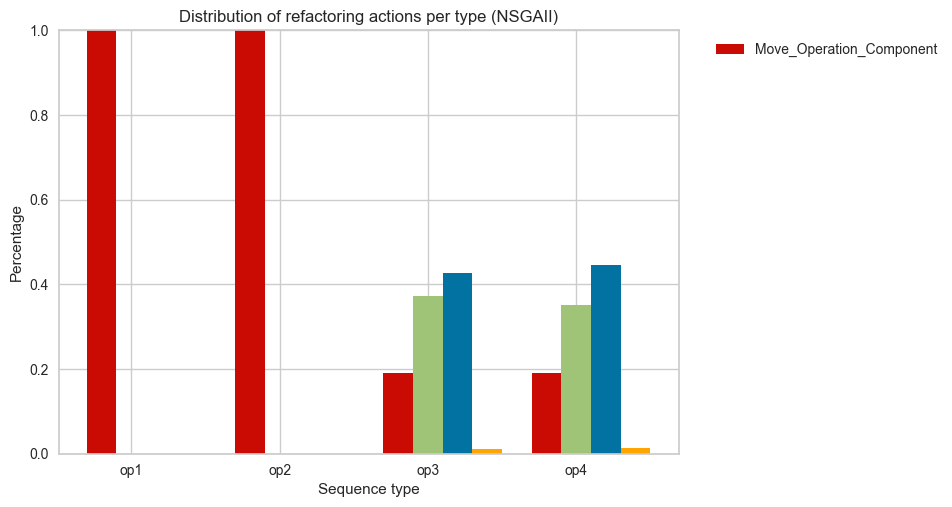

In [163]:
_ = it1_50_c358_space.plot_barchart_group(countops_it1_50_c358, title='(NSGAII)')

## **Iteration 0: (non-interactive, 100)**

In [164]:
it0_100_space.refactions_df.head()

solID                                    op1  \
0    948  Move_Operation_New_Component_New_Node   
1   1030  Move_Operation_New_Component_New_Node   
2   2351  Move_Operation_New_Component_New_Node   
3   2736  Move_Operation_New_Component_New_Node   
4   2749  Move_Operation_New_Component_New_Node   

                                     op2  \
0               Move_Operation_Component   
1  Move_Operation_New_Component_New_Node   
2  Move_Operation_New_Component_New_Node   
3               Move_Operation_Component   
4               Move_Operation_Component   

                                     op3  \
0  Move_Operation_New_Component_New_Node   
1  Move_Operation_New_Component_New_Node   
2               Move_Operation_Component   
3                Move_Component_New_Node   
4                Move_Component_New_Node   

                                     op4  
0  Move_Operation_New_Component_New_Node  
1                Move_Component_New_Node  
2               Move_Operation_Component  
3  Move_Operation_New_Component_New_Node  
4  Move_Operation_New_Component_New_Node

In [165]:
operations_ref100 = it0_100_space.get_candidate_operations()
#print(len(operations_ref100), operations_ref100)

refactions: 491
all operations: 1964


refactions: 491
all operations: 1964


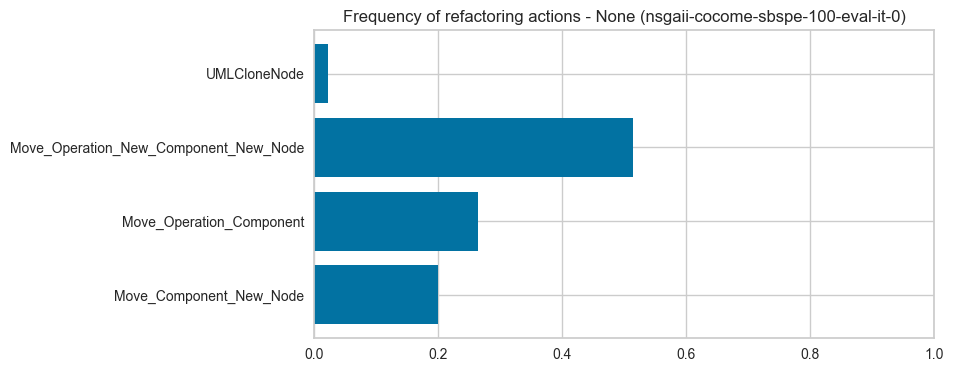

(array(['Move_Component_New_Node', 'Move_Operation_Component',
        'Move_Operation_New_Component_New_Node', 'UMLCloneNode'],
       dtype='<U37'),
 array([0.1990835 , 0.26425662, 0.51425662, 0.02240326]))

In [166]:
it0_100_space.show_refactions_distribution(size=(8,4), normalize=True)

refactions: 491
all operations: 491
refactions: 491
all operations: 491
refactions: 491
all operations: 491
refactions: 491
all operations: 491


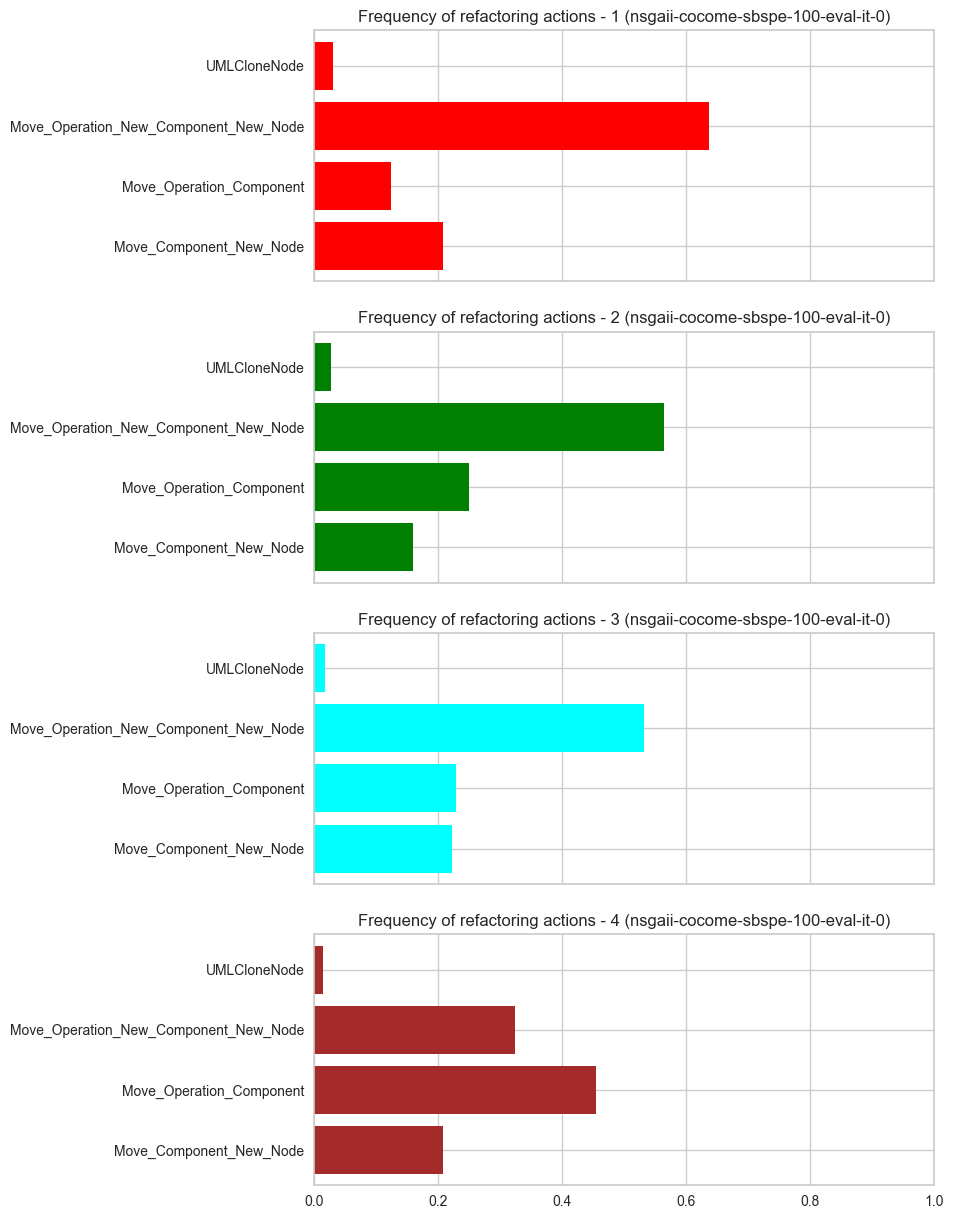

([array(['Move_Component_New_Node', 'Move_Operation_Component',
         'Move_Operation_New_Component_New_Node', 'UMLCloneNode'],
        dtype='<U37'),
  array(['Move_Component_New_Node', 'Move_Operation_Component',
         'Move_Operation_New_Component_New_Node', 'UMLCloneNode'],
        dtype='<U37'),
  array(['Move_Component_New_Node', 'Move_Operation_Component',
         'Move_Operation_New_Component_New_Node', 'UMLCloneNode'],
        dtype='<U37'),
  array(['Move_Component_New_Node', 'Move_Operation_Component',
         'Move_Operation_New_Component_New_Node', 'UMLCloneNode'],
        dtype='<U37')],
 [array([0.20773931, 0.12423625, 0.63747454, 0.0305499 ]),
  array([0.15885947, 0.25050916, 0.56415479, 0.02647658]),
  array([0.22199593, 0.22810591, 0.53156823, 0.01832994]),
  array([0.20773931, 0.45417515, 0.32382892, 0.01425662])])

In [167]:
countops_it0_100 = it0_100_space.show_refactions_distribution(size=(8,15), option=0, normalize=True)
countops_it0_100

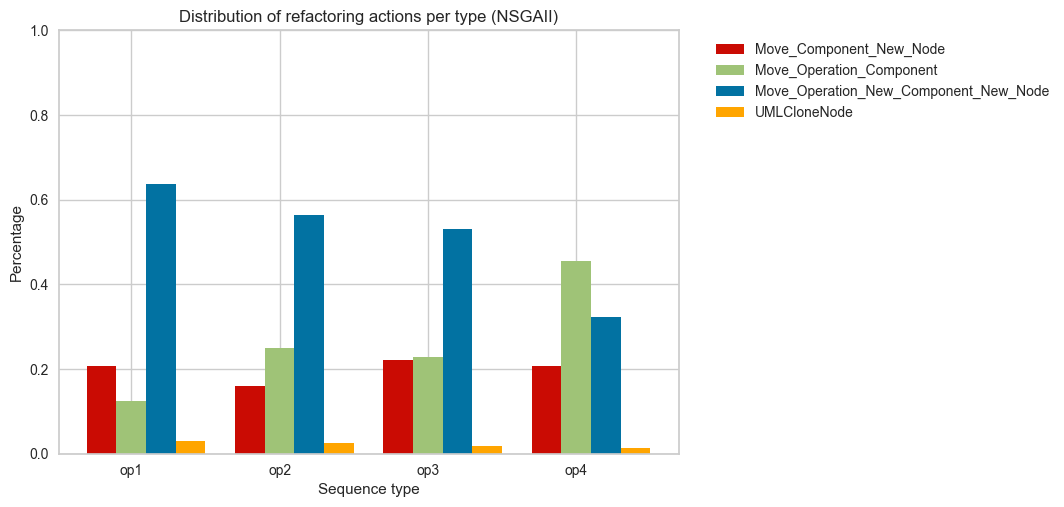

In [168]:
_ = it0_100_space.plot_barchart_group(countops_it0_100, title='(NSGAII)')

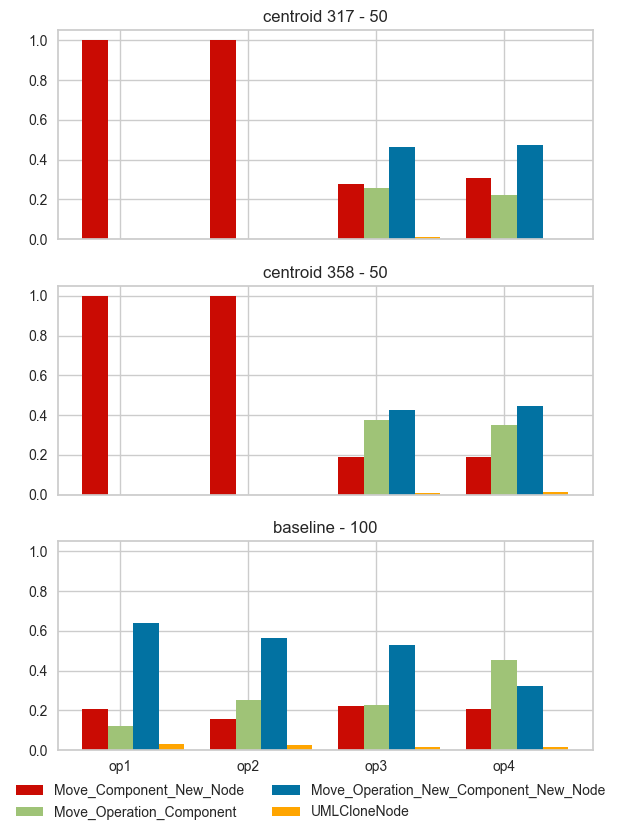

In [169]:
# Combination of all the plots for NSGAII
fig, axes = plt.subplots(3, sharey=True, sharex=True, figsize=(6,8))
#fig.suptitle('Frequency of actions per sequence position (train-ticket, NSGAII)')
#fig.suptitle('NSGAII (PF)')
lines, labels = it0_100_space.plot_barchart_group(countops_it1_50_c317, ax=axes[0], title='centroid 317 - 50')
lines, labels = it0_100_space.plot_barchart_group(countops_it1_50_c358, ax=axes[1], title='centroid 358 - 50')
lines, labels = it0_100_space.plot_barchart_group(countops_it0_100, ax=axes[2], title='baseline - 100')
fig.legend(lines, labels, ncol=2, loc='lower center', bbox_to_anchor=(0.5, -0.05), fontsize=10)
fig.tight_layout()
plt.show()

In [170]:
ALL_OPERATIONS = ['Move_Component_New_Node', 'Move_Operation_Component','Move_Operation_New_Component_New_Node', 'UMLCloneNode']

# This is a fix for the two particular cases of the centroids
countops_it1_50_c317[0][0] = np.array(ALL_OPERATIONS)
countops_it1_50_c317[0][1] = np.array(ALL_OPERATIONS)
countops_it1_50_c317[1][0] = [0.0] + [1. ] + [0.0, 0.0]
countops_it1_50_c317[1][1] = [0.0] + [1. ] + [0.0, 0.0]

countops_it1_50_c358[0][0] = np.array(ALL_OPERATIONS)
countops_it1_50_c358[0][1] = np.array(ALL_OPERATIONS)
countops_it1_50_c358[1][0] = [0.0] + [1. ] + [0.0, 0.0]
countops_it1_50_c358[1][1] = [0.0] + [1. ] + [0.0, 0.0]

In [171]:
REFACTIONS_NAMES = {
    'Move_Component_New_Node': 'ReDe',
    'Move_Operation_Component': 'MO2C',
    'Move_Operation_New_Component_New_Node': 'MO2N',
    'UMLCloneNode': 'Clon'
}

index1, index2, column1 = get_values_as_dataframe(countops_it1_50_c317, 'cocome (nsgaii)', 'c317')
_, _, column2 = get_values_as_dataframe(countops_it1_50_c358, 'cocome (nsgaii)', 'c358')
_, _, column3 = get_values_as_dataframe(countops_it0_100, 'cocome (nsgaii)', 'baseline')
all_columns = {k: v for d in [column1, column2, column3] for k, v in d.items()}
all_df = pd.DataFrame(data=all_columns, index=[index1,index2])
all_df = all_df.reset_index().rename(columns={'level_0':'pos', 'level_1': 'ref. actions'})
all_df['pos'] = [1]*4 + [2]*4 + [3]*4 + [4]*4
all_df[('ref. actions', '')] = all_df[('ref. actions', '')].replace(REFACTIONS_NAMES)
all_df.to_csv('./datasets/nsgaii-refactions-cocome.csv', index=False)
all_df

pos ref. actions cocome (nsgaii)                    
                               c317      c358  baseline
0    1         ReDe        0.000000  0.000000  0.207739
1    1         MO2C        1.000000  1.000000  0.124236
2    1         MO2N        0.000000  0.000000  0.637475
3    1         Clon        0.000000  0.000000  0.030550
4    2         ReDe        0.000000  0.000000  0.158859
5    2         MO2C        1.000000  1.000000  0.250509
6    2         MO2N        0.000000  0.000000  0.564155
7    2         Clon        0.000000  0.000000  0.026477
8    3         ReDe        0.276768  0.189516  0.221996
9    3         MO2C        0.254545  0.372984  0.228106
10   3         MO2N        0.460606  0.427419  0.531568
11   3         Clon        0.008081  0.010081  0.018330
12   4         ReDe        0.307071  0.189516  0.207739
13   4         MO2C        0.220202  0.350806  0.454175
14   4         MO2N        0.470707  0.445565  0.323829
15   4         Clon        0.002020  0.014113  0.014257

In [172]:
# Showing it styled
cmap = sns.color_palette('viridis_r', as_cmap=True)
styled_df = all_df.style.background_gradient(cmap=cmap, subset=list(all_columns.keys()), vmin=0.0, vmax=1.0).format(precision=2).hide()
styled_df

In [173]:
#!pip install imgkit --quiet # For rendering images from HTML tables

In [174]:
#!sudo apt-get install wkhtmltopdf

In [175]:
#import imgkit
# Conversion to an image
#html = styled_df.to_html()
#imgkit.from_string(html, 'styled_table.png')
#Image.open('styled_table.png')

## **Comparison of prefix trees (types)**

In [201]:
# We need to consolidate all the refactoring actions of all the iterations
all_operations = set()
all_operations = all_operations.union(operations_ref1000, operations_centroid317, operations_centroid358, operations_ref100)

print("Operation reference (1000): ", len(operations_ref1000), len(set(operations_ref1000)))
print("Operation centroid-317 (50): ", len(operations_centroid317), len(set(operations_centroid317)))
print("Operation centroid-358 (50): ", len(operations_centroid358), len(set(operations_centroid358)))
print("Operation reference (100): ", len(operations_ref100), len(set(operations_ref100)))
print("All operations (intersection): ", len(all_operations))

# This is an encoder for all the iterations
global_le = ref1000_space.create_encoder(all_operations)

Operation reference (1000):  1968 4
Operation centroid-317 (50):  1980 4
Operation centroid-358 (50):  1984 4
Operation reference (100):  1964 4
All operations (intersection):  4


### *Codes and trees for Reference Pareto Front*

In [202]:
codes, encoder = ref1000_space.get_codes(use_alphabet=True, encoder=global_le)
unique_codes_ref1000 = dict(codes) # Note that duplicate codes are discarded (only one of the duplicates is kept)

refactions: 492
all operations: 1968
4 Distinct (individual) refactoring actions: {'Move_Component_New_Node', 'UMLCloneNode', 'Move_Operation_New_Component_New_Node', 'Move_Operation_Component'}
encoding refactions: 492
Sequence codes: 492 [('aaca', 17566), ('bccb', 17811), ('bcbb', 22051), ('bcab', 22521), ('cacb', 22660), ('cccb', 25867), ('ccbc', 26428), ('ccbc', 27890), ('cacb', 27924), ('bbbb', 28700), ('cacb', 28822), ('bccb', 28764), ('accb', 28827), ('ccbc', 28860), ('cacb', 28871), ('acac', 7713), ('cacb', 18980), ('cccb', 20006), ('bcac', 28233), ('acab', 28647), ('cccb', 28679), ('cbcb', 28765), ('cccb', 28882), ('bacc', 28480), ('bacc', 28867), ('acbc', 28794), ('ccac', 28418), ('accb', 28881), ('ccbc', 28420), ('cccb', 28650), ('cdbb', 28687), ('caac', 1655), ('cbac', 4799), ('ccbb', 5623), ('cccb', 9279), ('bcbb', 13180), ('bbbb', 18717), ('bbbb', 19635), ('cbbb', 23146), ('cbbb', 24553), ('acbb', 26821), ('bccc', 27955), ('accb', 28404), ('cacb', 28692), ('cccb', 28717),

hamming


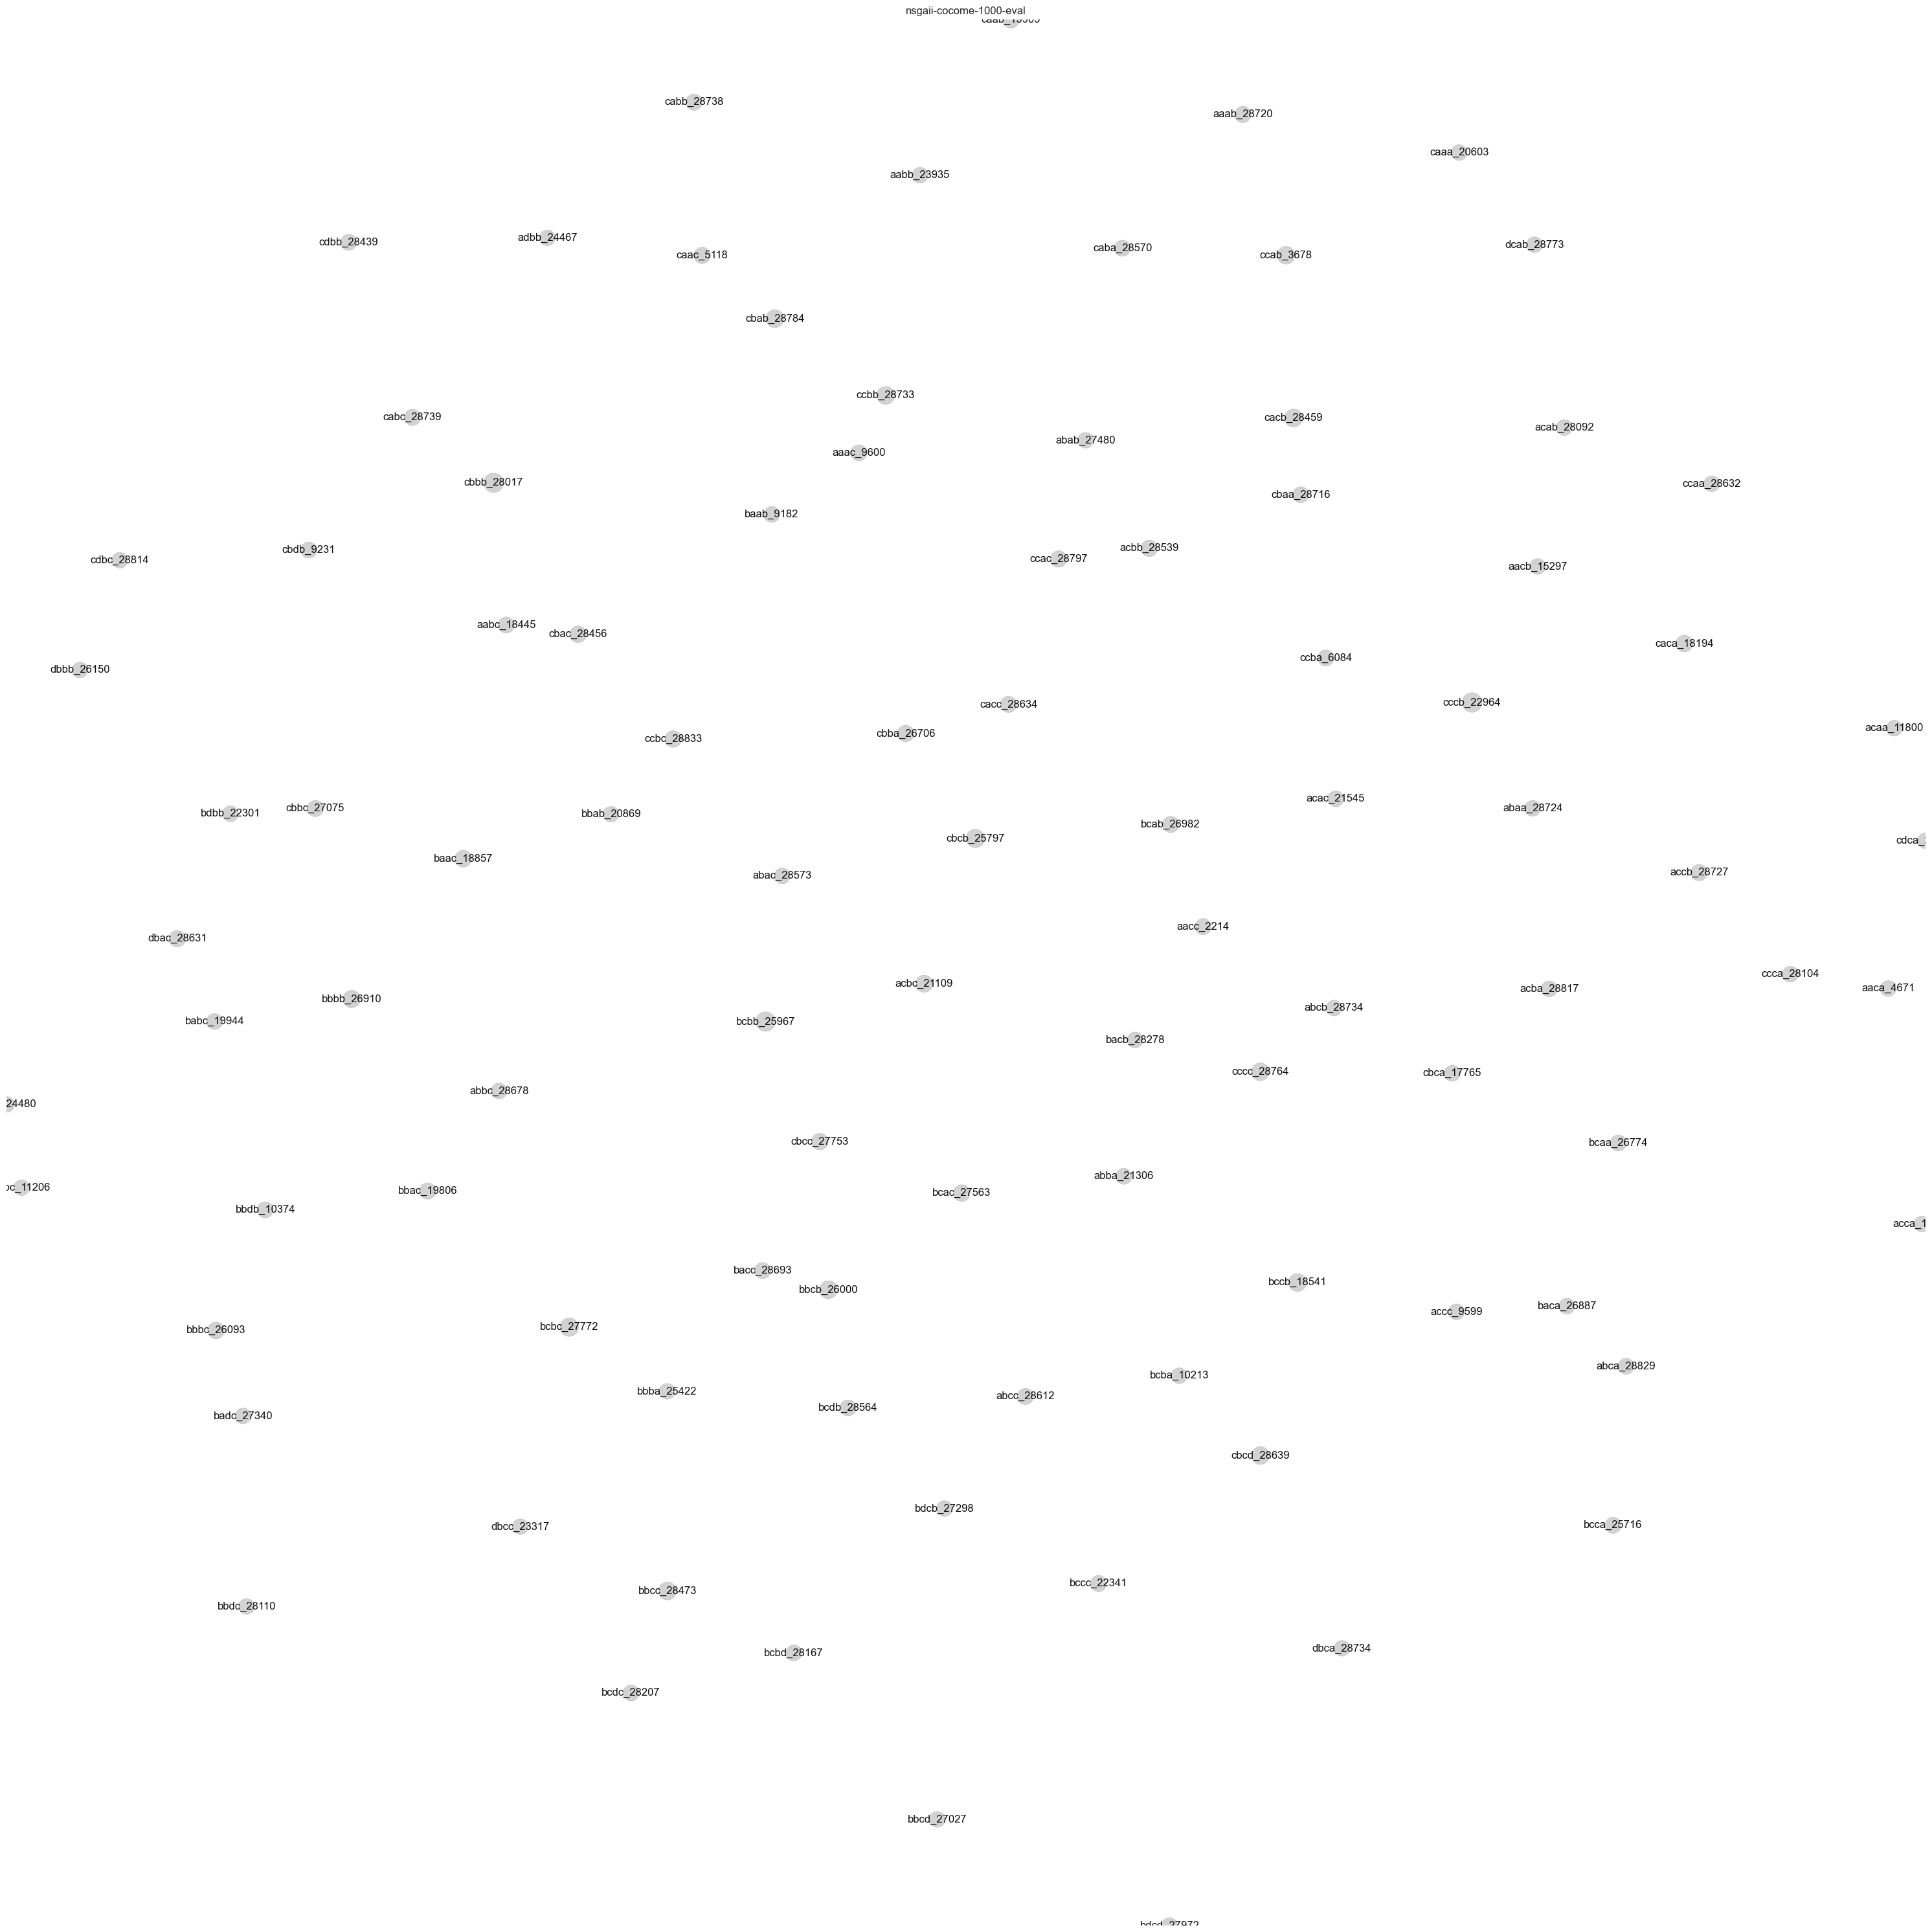

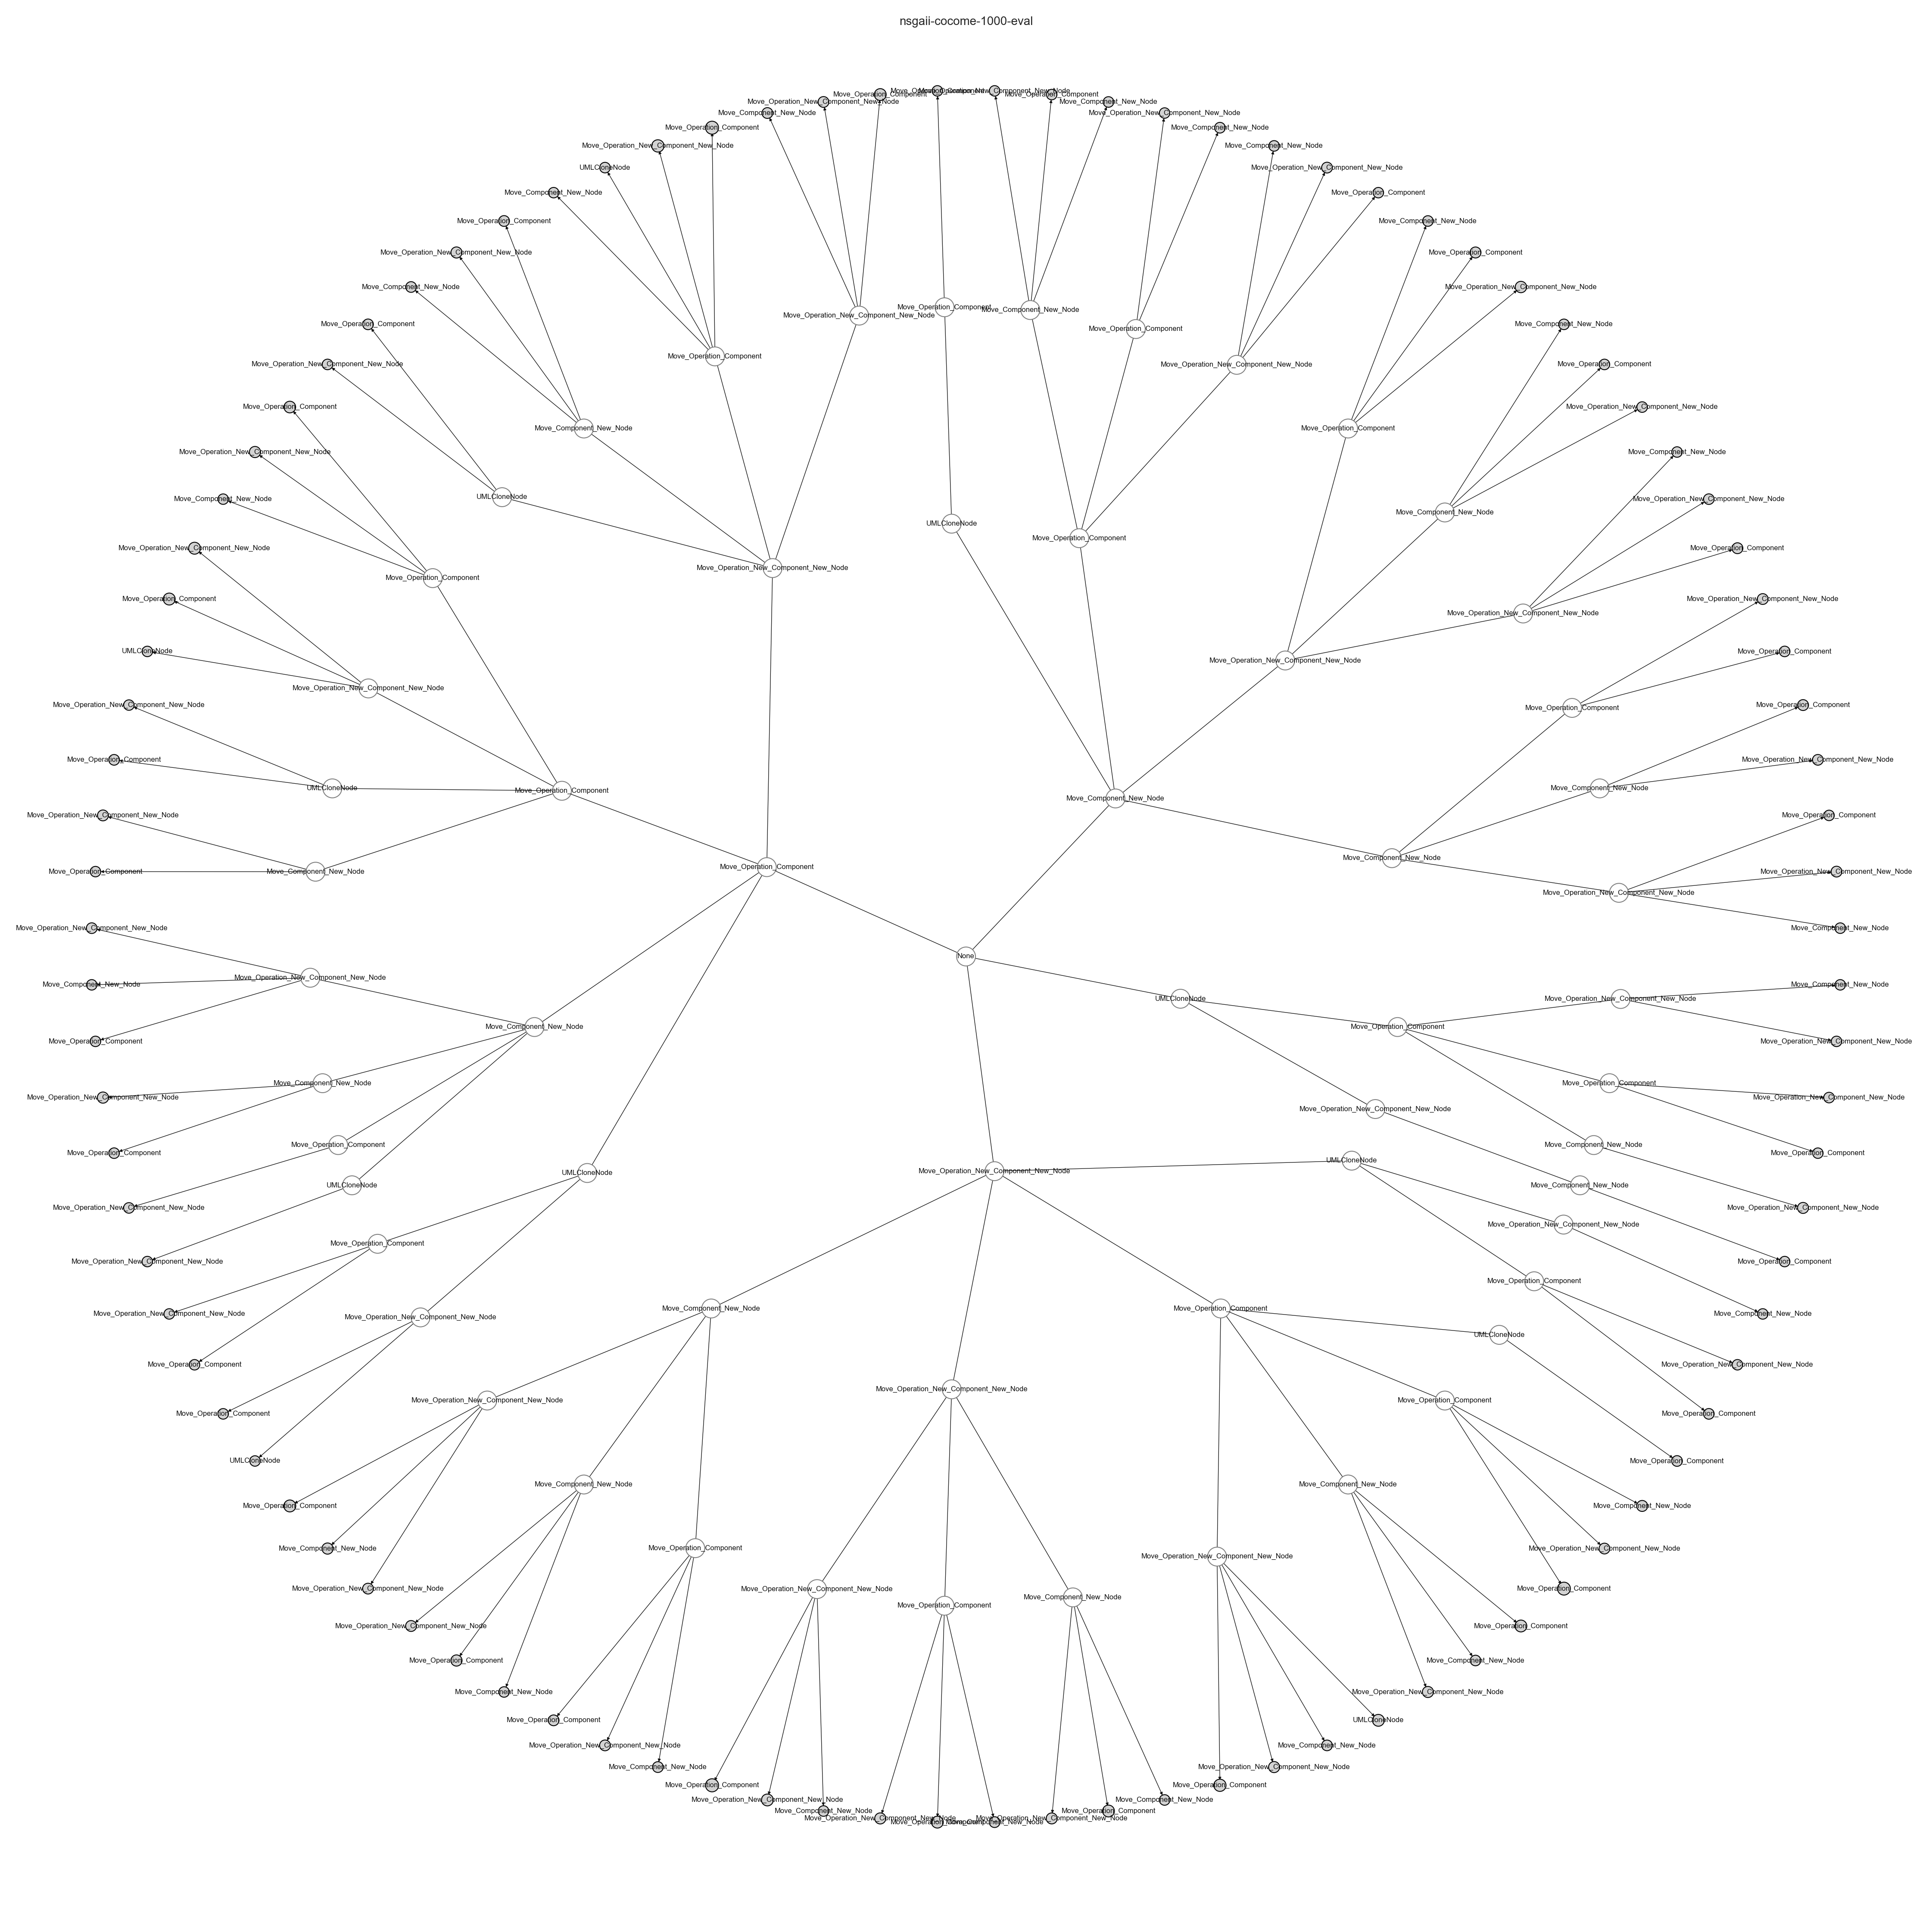

In [203]:
_ = ref1000_space.get_sequence_graph(unique_codes_ref1000, size=(30,30), show=True, info=None, metric='hamming') #metric='damerauLevenshtein') 
ref1000_trie = ref1000_space.get_prefix_tree(unique_codes_ref1000, size=(45,45), prog='twopi', info=None, encoder=global_le)
#ref1000_space.describe_cluster_labels()

In [204]:
nx.drawing.nx_pydot.write_dot(ref1000_trie, './datasets/it0_1000_baseline_trie.dot')

### *Codes and trees for Iteration 1 - Centroid 317*

In [205]:
codes, encoder = it1_50_c317_space.get_codes(use_alphabet=True, encoder=global_le)
unique_codes_centroid317 = dict(codes) # Note that duplicate codes are discarded (only one of the duplicates is kept)

refactions: 495
all operations: 1980
4 Distinct (individual) refactoring actions: {'Move_Component_New_Node', 'UMLCloneNode', 'Move_Operation_New_Component_New_Node', 'Move_Operation_Component'}
encoding refactions: 495
Sequence codes: 495 [('bbba', 148), ('bbbc', 342), ('bbbc', 354), ('bbcc', 733), ('bbab', 1077), ('bbcc', 1007), ('bbcc', 1278), ('bbcc', 1279), ('bbca', 1300), ('bbcc', 1457), ('bbba', 1255), ('bbac', 1445), ('bbac', 91), ('bbcc', 1354), ('bbcc', 1444), ('bbac', 1425), ('bbcc', 234), ('bbca', 527), ('bbac', 680), ('bbca', 1012), ('bbac', 1427), ('bbcc', 1433), ('bbba', 1293), ('bbcc', 583), ('bbcc', 431), ('bbac', 1133), ('bbcc', 1431), ('bbca', 1094), ('bbca', 1335), ('bbcc', 1419), ('bbcc', 1239), ('bbcc', 1360), ('bbba', 440), ('bbca', 606), ('bbbb', 1118), ('bbaa', 1211), ('bbcc', 1363), ('bbaa', 1161), ('bbac', 1395), ('bbab', 938), ('bbba', 343), ('bbaa', 1309), ('bbbc', 1263), ('bbaa', 1425), ('bbcc', 1393), ('bbac', 1346), ('bbac', 1377), ('bbac', 1420), ('bbcc

hamming


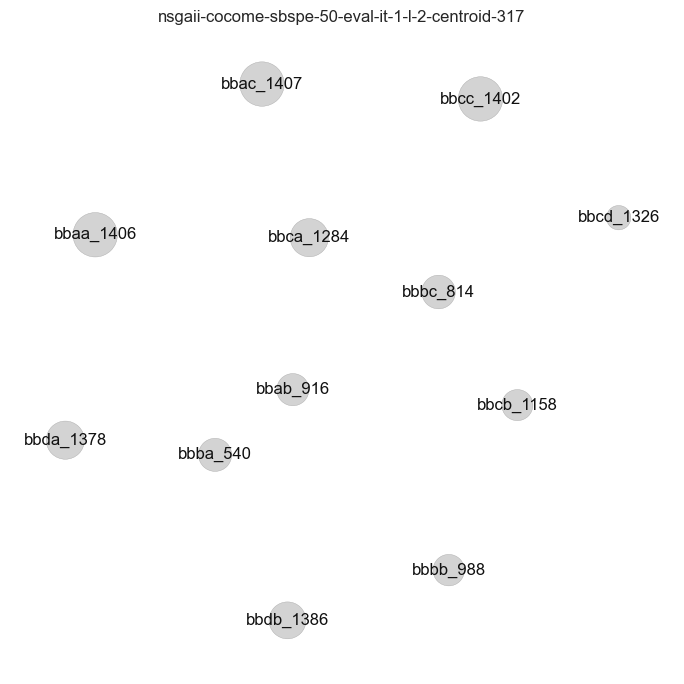

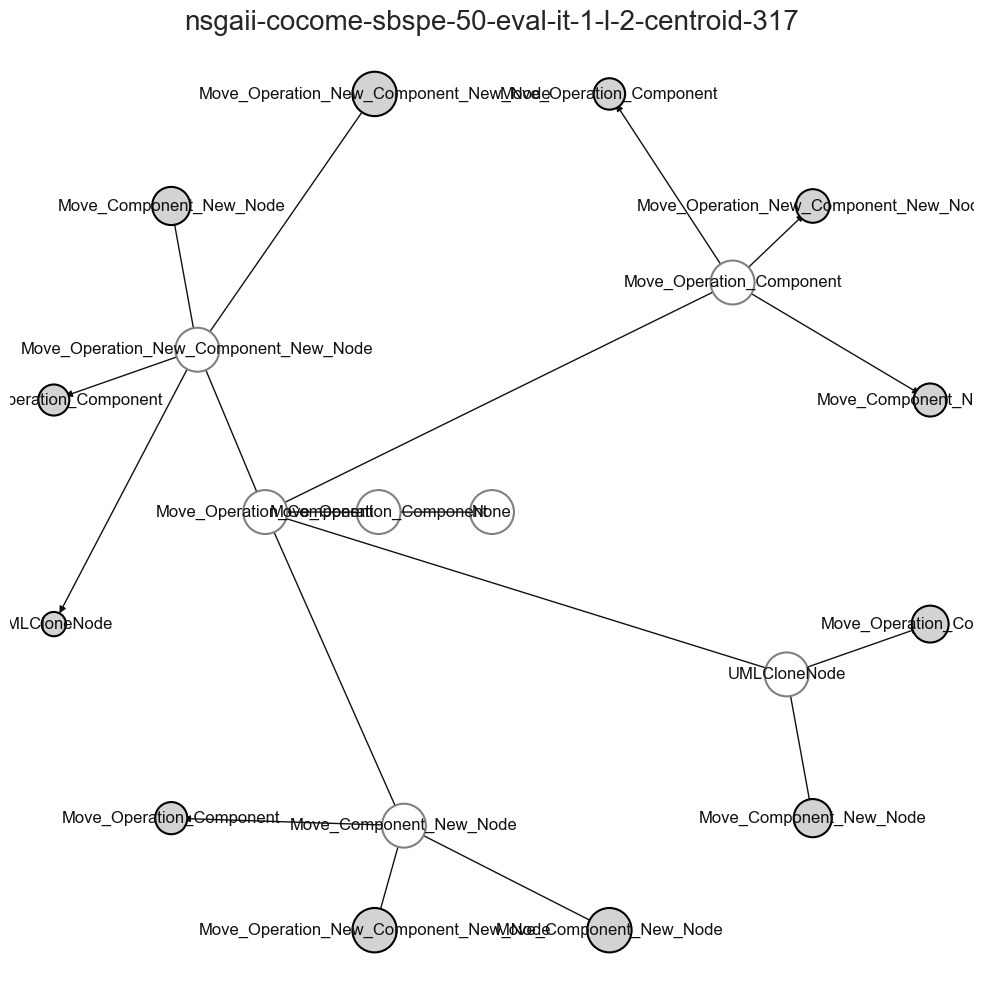

In [206]:
_ = it1_50_c317_space.get_sequence_graph(unique_codes_centroid317, size=(7,7), show=True, info=None, metric='hamming', margin=0.1) #, metric='damerauLevenshtein') 
it1_50_c317_trie = it1_50_c317_space.get_prefix_tree(unique_codes_centroid317, size=(10,10), prog='twopi', info=None, encoder=global_le)
#it1_50_c317_space.describe_cluster_labels()

In [207]:
nx.drawing.nx_pydot.write_dot(it1_50_c317_trie, './datasets/it1_50_c317_trie.dot')

### *Codes and trees for Iteration 1 - Centroid 358*

In [208]:
codes, encoder = it1_50_c358_space.get_codes(use_alphabet=True, encoder=global_le)
unique_codes_centroid358= dict(codes) # Note that duplicate codes are discarded (only one of the duplicates is kept)

refactions: 496
all operations: 1984
4 Distinct (individual) refactoring actions: {'Move_Component_New_Node', 'UMLCloneNode', 'Move_Operation_New_Component_New_Node', 'Move_Operation_Component'}
encoding refactions: 496
Sequence codes: 496 [('bbbc', 145), ('bbcb', 155), ('bbcc', 463), ('bbac', 509), ('bbcc', 534), ('bbcc', 1345), ('bbba', 1382), ('bbcb', 1405), ('bbcb', 1436), ('bbcc', 896), ('bbab', 1234), ('bbbc', 1316), ('bbbb', 964), ('bbbc', 1136), ('bbca', 1413), ('bbcb', 1440), ('bbcc', 884), ('bbac', 966), ('bbcb', 1190), ('bbca', 1263), ('bbbc', 1310), ('bbbb', 1314), ('bbbc', 1295), ('bbab', 1412), ('bbbc', 889), ('bbcc', 1202), ('bbbc', 1068), ('bbcb', 1266), ('bbcb', 1405), ('bbba', 1413), ('bbcb', 876), ('bbcb', 1421), ('bbcc', 494), ('bbac', 518), ('bbbc', 1001), ('bbcb', 1179), ('bbca', 1265), ('bbab', 1390), ('bbcb', 1336), ('bbca', 800), ('bbab', 1088), ('bbca', 1320), ('bbbc', 1252), ('bbac', 1402), ('bbcc', 1249), ('bbca', 1368), ('bbbc', 1167), ('bbcc', 1406), ('bbc

hamming


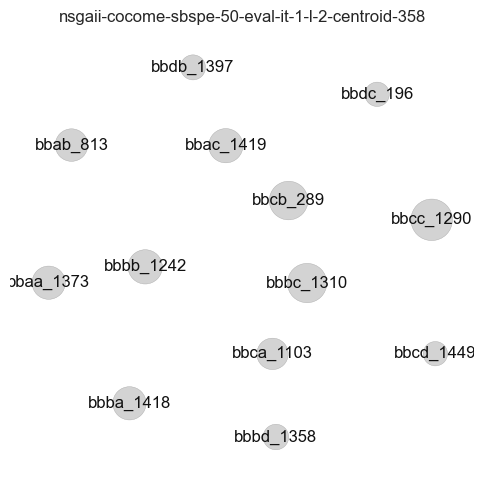

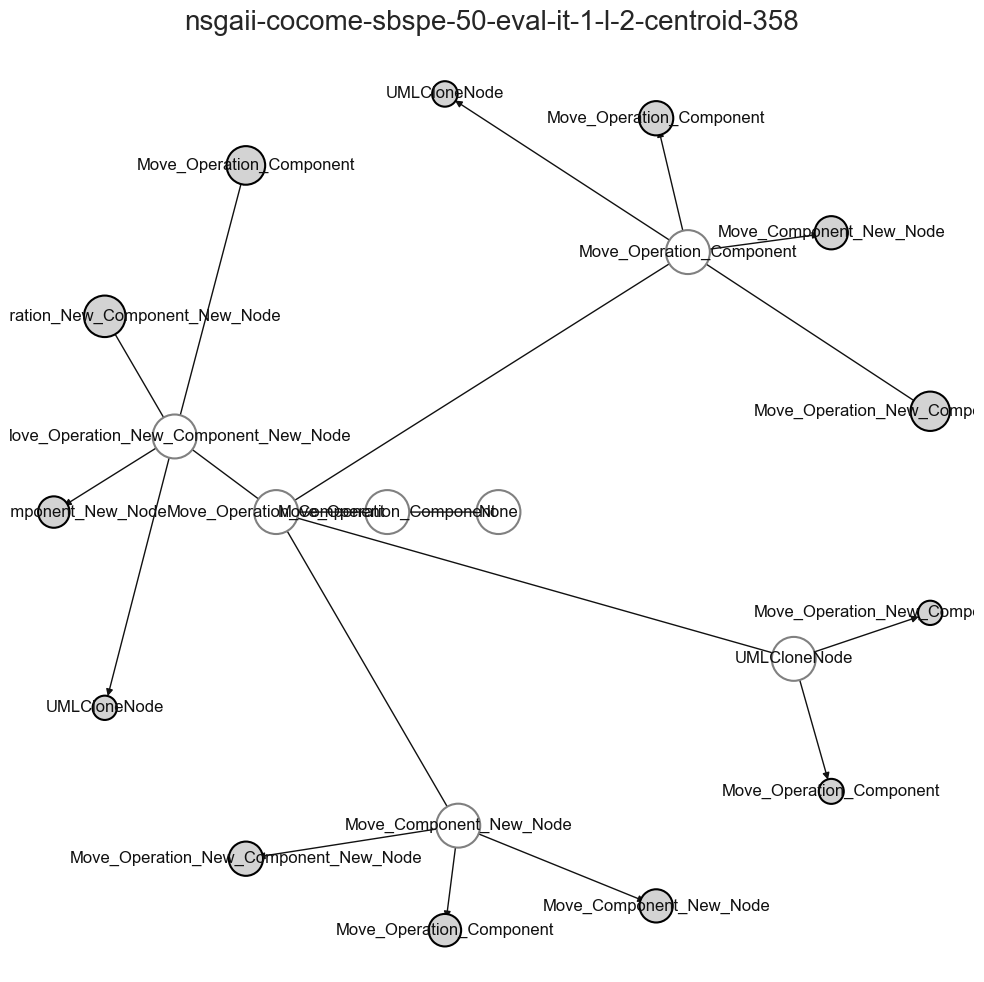

In [209]:
_ = it1_50_c358_space.get_sequence_graph(unique_codes_centroid358, size=(5,5), show=True, info=None, metric='hamming', margin=0.1) #, metric='damerauLevenshtein') 
it1_50_c358_trie = it1_50_c358_space.get_prefix_tree(unique_codes_centroid358, size=(10,10), prog='twopi', info=None, encoder=global_le)
#it1_50_c358_space.describe_cluster_labels()

In [210]:
nx.drawing.nx_pydot.write_dot(it1_50_c358_trie, './datasets/it1_50_c358_trie.dot')

### *Codes and trees for Iteration 0 - No interaction*

In [211]:
codes, encoder = it0_100_space.get_codes(use_alphabet=True, encoder=global_le)
unique_codes_ref100 = dict(codes) # Note that duplicate codes are discarded (only one of the duplicates is kept)

refactions: 491
all operations: 1964
4 Distinct (individual) refactoring actions: {'Move_Component_New_Node', 'UMLCloneNode', 'Move_Operation_New_Component_New_Node', 'Move_Operation_Component'}
encoding refactions: 491
Sequence codes: 491 [('cbcc', 948), ('ccca', 1030), ('ccbb', 2351), ('cbac', 2736), ('cbac', 2749), ('bacb', 2775), ('acbb', 581), ('abbb', 1808), ('bcab', 2675), ('bcca', 2792), ('bcac', 2818), ('cacb', 2850), ('ccac', 2851), ('cbcc', 1413), ('ccba', 1644), ('ccca', 1682), ('cccc', 1743), ('ccab', 2288), ('accb', 2389), ('cbbc', 2506), ('ccab', 2528), ('ccab', 2695), ('cacb', 1067), ('bcab', 2709), ('dccb', 2797), ('cccc', 2728), ('cccb', 2817), ('accb', 662), ('dbcb', 1541), ('cccb', 1970), ('cdbd', 1999), ('caac', 2006), ('accb', 2175), ('cdbd', 2217), ('dcdb', 2607), ('bbcc', 2706), ('acab', 2809), ('ccbb', 2721), ('ccbb', 2730), ('cccb', 2858), ('dbcd', 2799), ('cccb', 2819), ('cccb', 2859), ('acdb', 477), ('cccc', 823), ('caab', 1578), ('acba', 2482), ('acbc', 246

hamming


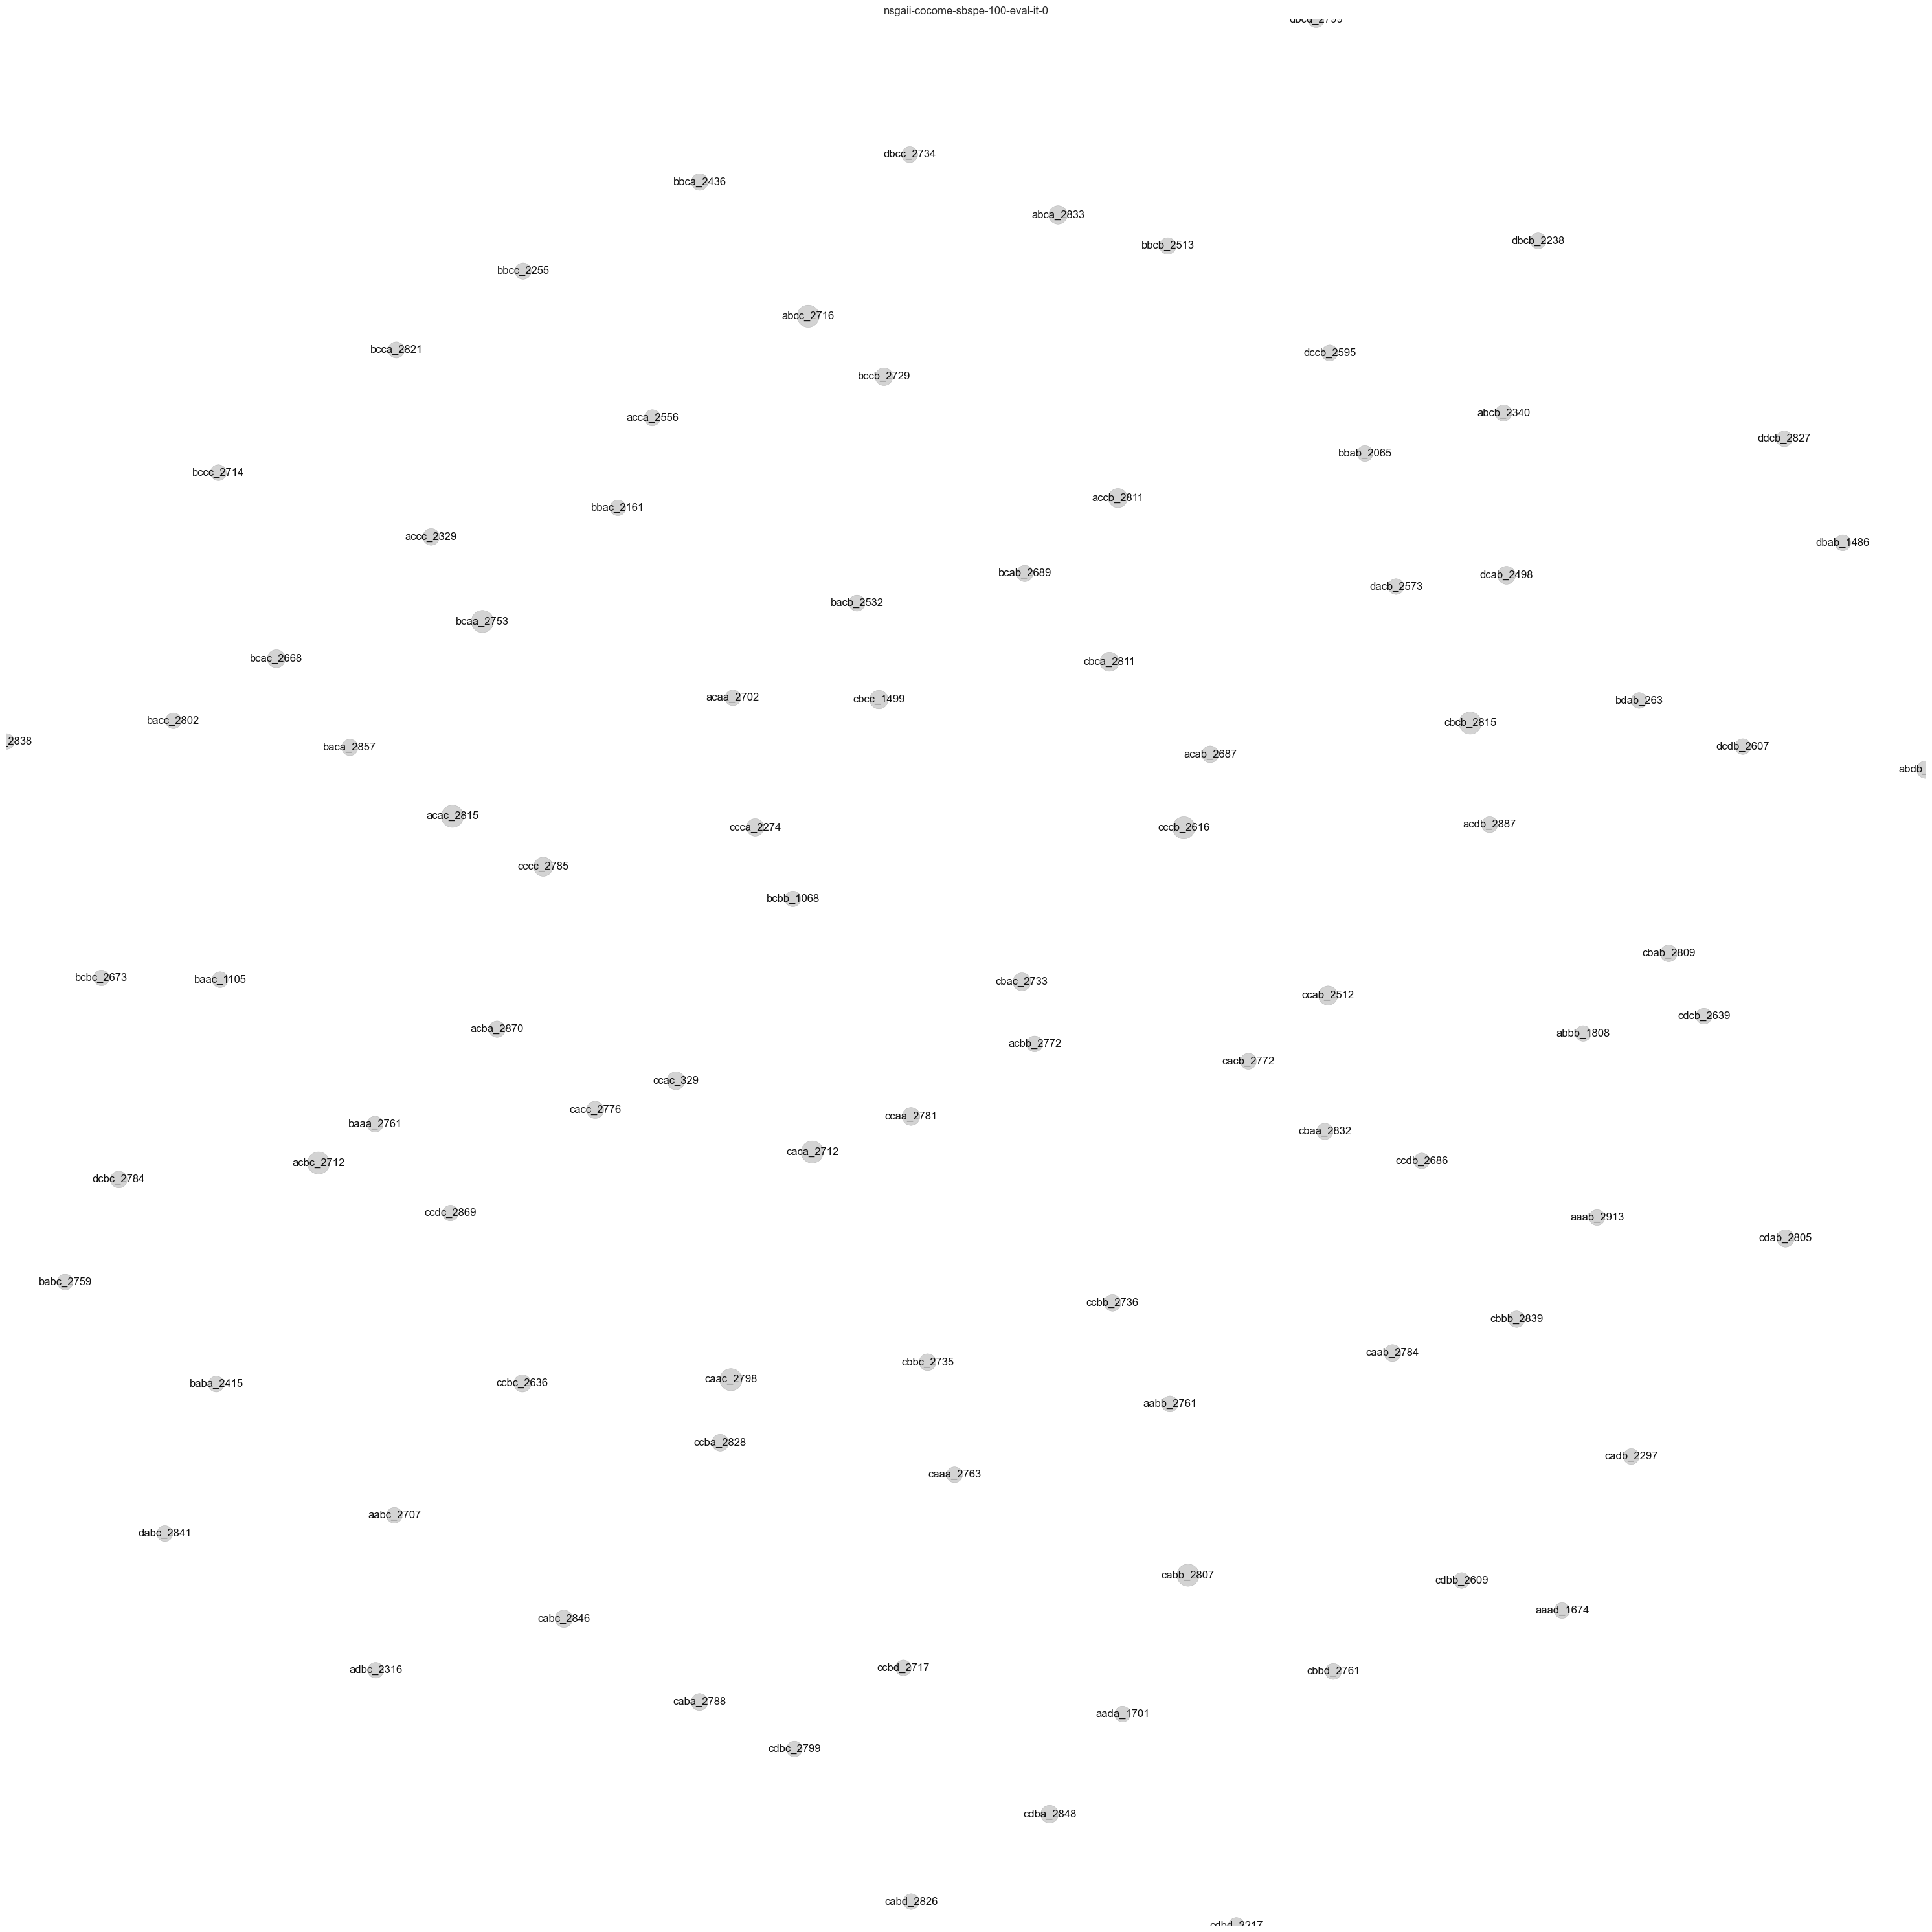

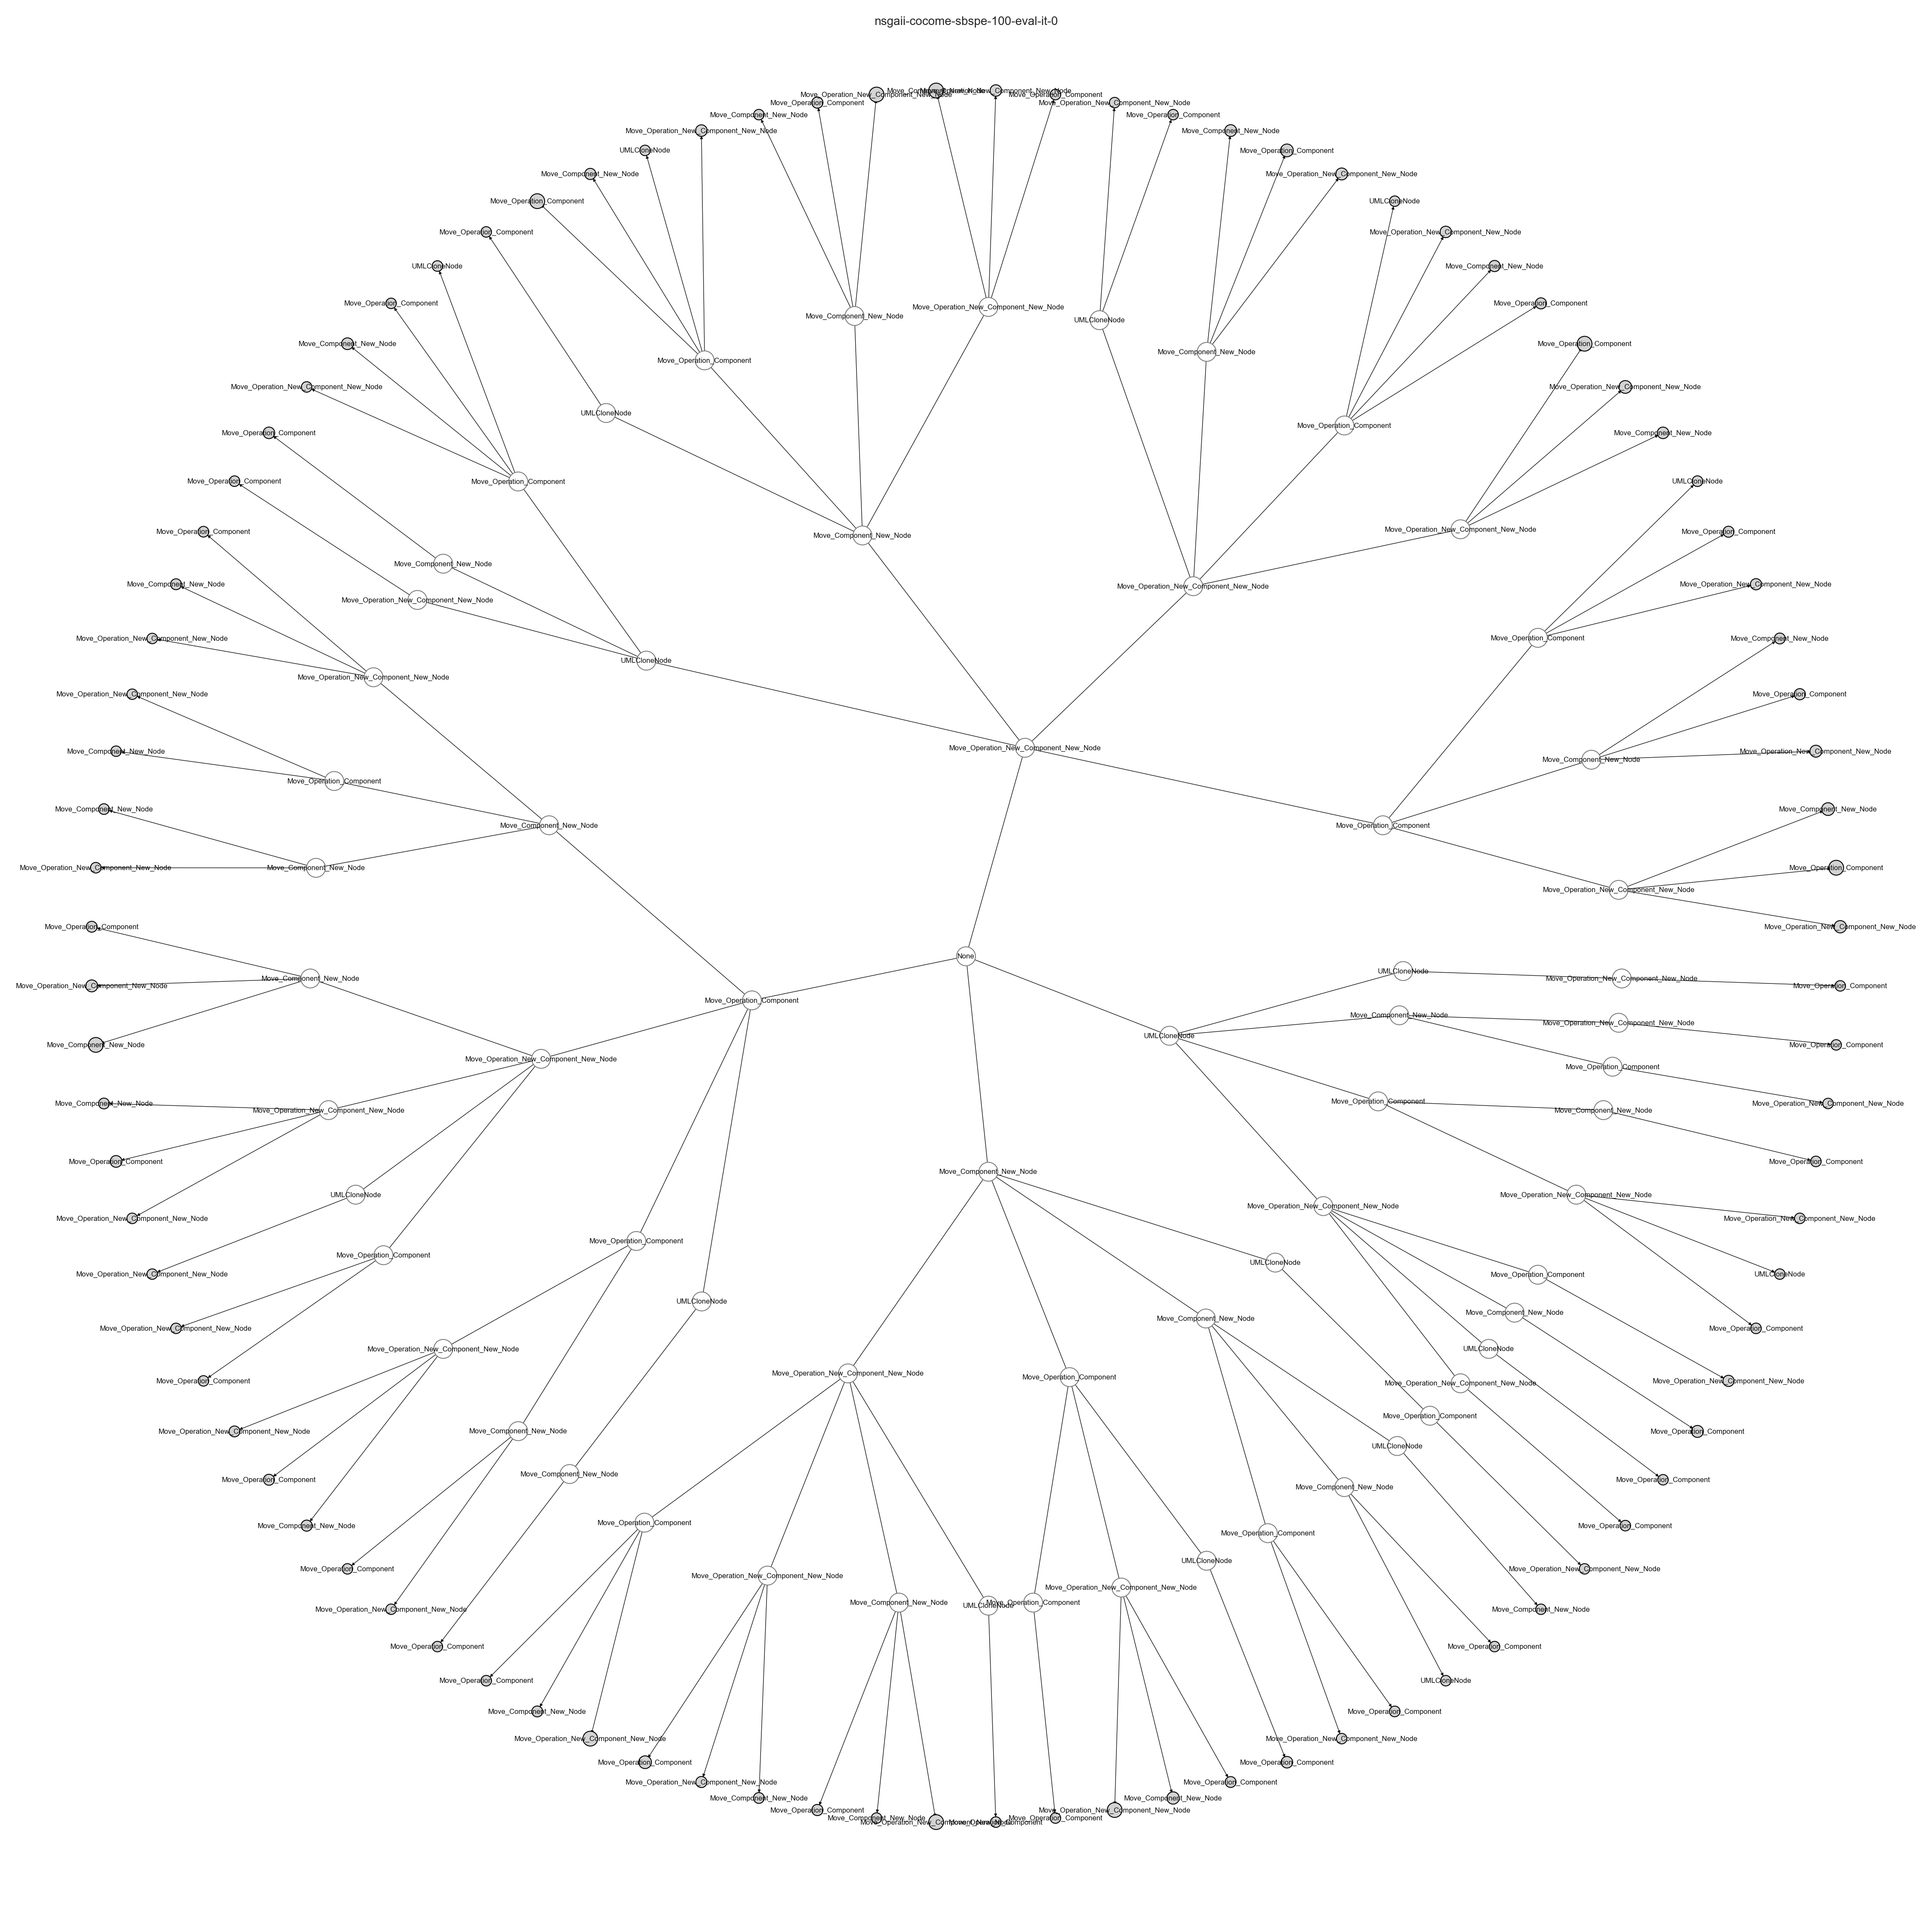

In [212]:
_ = it0_100_space.get_sequence_graph(unique_codes_ref100, size=(30,30), show=True, info=None, metric='hamming') #, metric='damerauLevenshtein') 
ref100_trie = it0_100_space.get_prefix_tree(unique_codes_ref100, size=(45,45), prog='twopi', info=None, encoder=global_le)
#it0_100_space.describe_cluster_labels()

In [213]:
nx.drawing.nx_pydot.write_dot(ref100_trie, './datasets/it0_100_baseline_trie.dot')

### *Computing tree distances*

In [214]:
# Garbage Collector - use it like gc.collect()
#import gc
#gc.collect()

In [215]:
print("Trie size for reference (1000):", ref1000_trie.number_of_nodes())
print("Trie size for centroid-317 (50):", it1_50_c317_trie.number_of_nodes())
print("Trie size for centroid-358 (50):", it1_50_c358_trie.number_of_nodes())
print("Trie size for reference (100):", ref100_trie.number_of_nodes())

Trie size for reference (1000): 155
Trie size for centroid-317 (50): 19
Trie size for centroid-358 (50): 20
Trie size for reference (100): 157


In [216]:
print('===== Trie for Reference (1000)')
print("\tcentroid-317", ArchitectureSpaceAnalyzer.compute_zss_distance_for_tries(ref1000_trie, it1_50_c317_trie))
print("\tcentroid-358", ArchitectureSpaceAnalyzer.compute_zss_distance_for_tries(ref1000_trie, it1_50_c358_trie))
print("\treference-100", ArchitectureSpaceAnalyzer.compute_zss_distance_for_tries(ref1000_trie, ref100_trie))

===== Trie for Reference (1000)
root: 0 <class 'str'>
root: 0 <class 'str'>
	centroid-317 148.0
root: 0 <class 'str'>
root: 0 <class 'str'>
	centroid-358 148.0
root: 0 <class 'str'>
root: 0 <class 'str'>
	reference-100 140.0


In [217]:
print('===== Trie for Reference (100)')
print("\tcentroid-317", ArchitectureSpaceAnalyzer.compute_zss_distance_for_tries(ref100_trie, it1_50_c317_trie))
print("\tcentroid-358", ArchitectureSpaceAnalyzer.compute_zss_distance_for_tries(ref100_trie, it1_50_c358_trie))

===== Trie for Reference (100)
root: 0 <class 'str'>
root: 0 <class 'str'>
	centroid-317 145.0
root: 0 <class 'str'>
root: 0 <class 'str'>
	centroid-358 151.0


In [218]:
print('===== centroid-317 versus centroid-358')
print("\t", ArchitectureSpaceAnalyzer.compute_zss_distance_for_tries(it1_50_c317_trie, it1_50_c358_trie))

===== centroid-317 versus centroid-358
root: 0 <class 'str'>
root: 0 <class 'str'>
	 10.0


## **Comparison of sequences (types)**

In [219]:
sequences_ref1000 = set(unique_codes_ref1000.keys())
sequences_centroid317 = set(unique_codes_centroid317.keys())
sequences_centroid358 = set(unique_codes_centroid358.keys())
sequences_ref100 = set(unique_codes_ref100.keys())

Union of solutions: 14


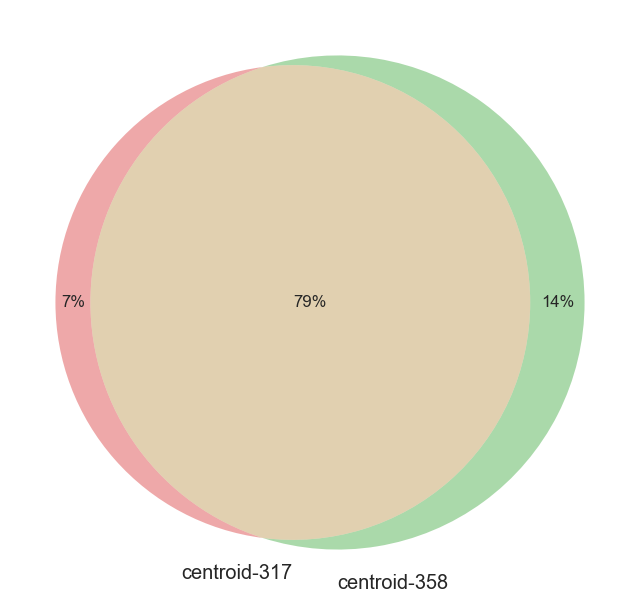

In [220]:
fig = plt.figure(figsize=(8,8))
plot2([sequences_centroid317, sequences_centroid358], ['centroid-317', 'centroid-358'])
plt.show()

Union of solutions: 125


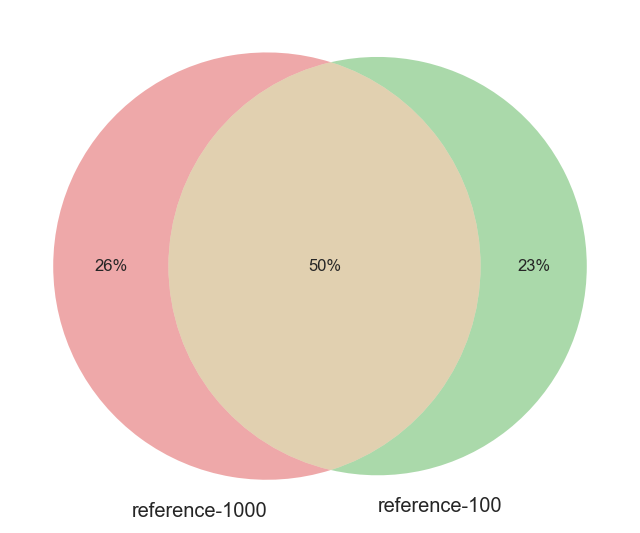

In [221]:
fig = plt.figure(figsize=(8,8))
plot2([sequences_ref1000, sequences_ref100], ['reference-1000', 'reference-100'])
plt.show()

Union of solutions: 99


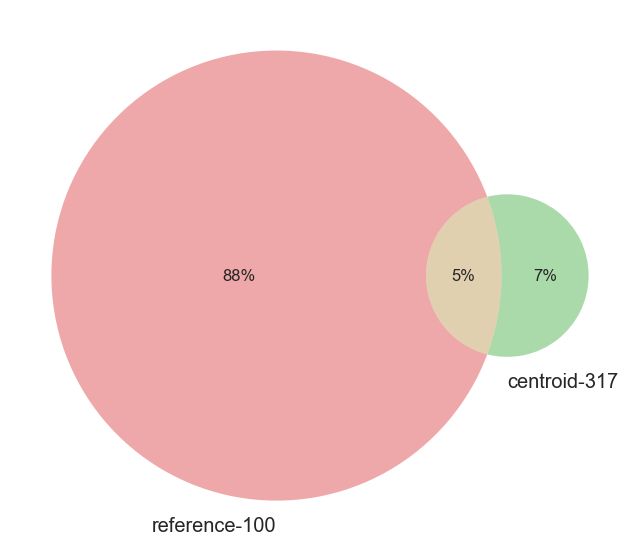

In [222]:
fig = plt.figure(figsize=(8,8))
plot2([sequences_ref100, sequences_centroid317], ['reference-100', 'centroid-317'])
plt.show()

Union of solutions: 100


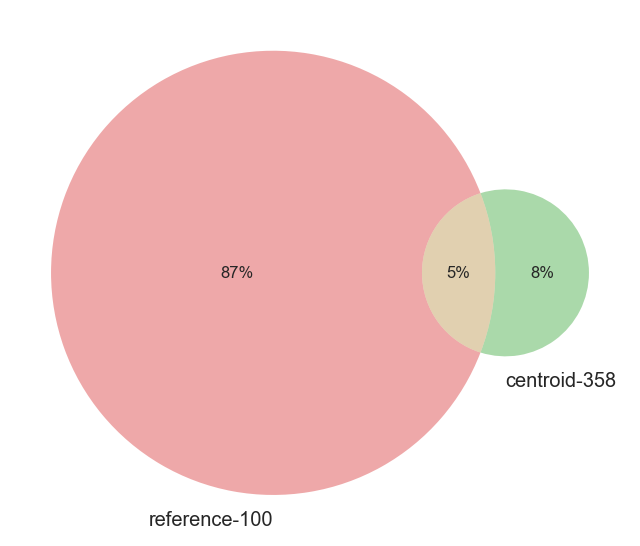

In [223]:
fig = plt.figure(figsize=(8,8))
plot2([sequences_ref100, sequences_centroid358], ['reference-100', 'centroid-358'])
plt.show()

Union of solutions: 101


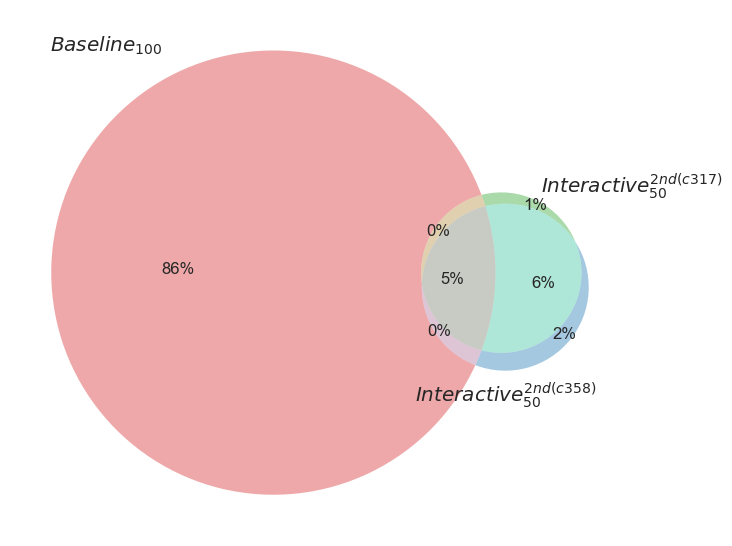

In [224]:
fig = plt.figure(figsize=(8,8))
plot3([sequences_ref100, sequences_centroid317, sequences_centroid358], ['$Baseline_{100}$','$Interactive_{50}^{2nd(c317)}$','$Interactive_{50}^{2nd(c358)}$'])
plt.show()

Union of solutions: 101
Union of solutions: 14
Union of solutions: 125


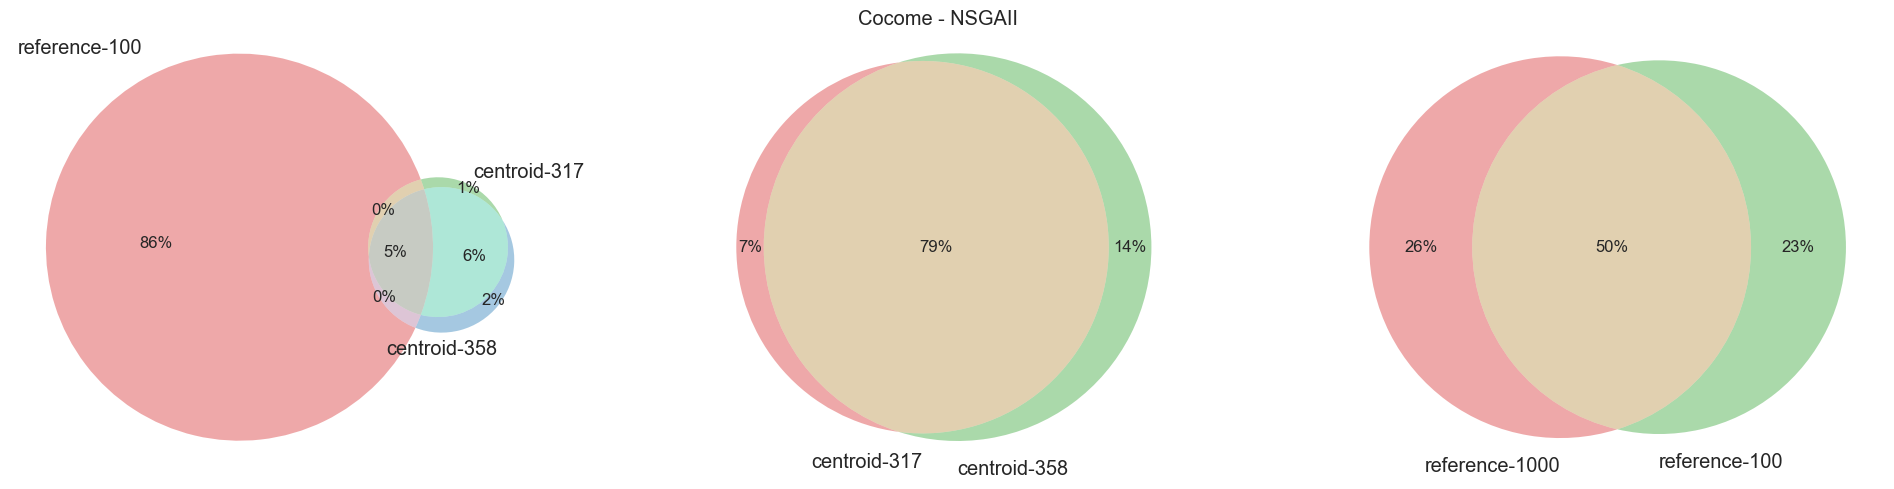

In [225]:
fig, axes = plt.subplots(1, 3, figsize=(20,5))
plot3([sequences_ref100, sequences_centroid317, sequences_centroid358], ['reference-100','centroid-317','centroid-358'], ax=axes[0])
plot2([sequences_centroid317, sequences_centroid358], ['centroid-317', 'centroid-358'], ax=axes[1])
plot2([sequences_ref1000, sequences_ref100], ['reference-1000', 'reference-100'], ax=axes[2])
plt.tight_layout()
plt.suptitle('Cocome - NSGAII')
plt.show()

---